# ADA Project: 2018's Best Hit Recipe 🎙🎵

## Table of Contents
    
<div class="lev1"><a href="#Million-Song-Dataset-subset">
<span class="toc-item-num">1 :&nbsp;&nbsp;</span>Million Song Dataset subset</a></div>
<div class="lev3"><a href="#Retrieving-the-dataframe">
<span class="toc-item-num">1.1 :&nbsp;&nbsp;</span>Retrieving the dataframe</a></div>
<div class="lev3"><a href="#Basic-statistics">
<span class="toc-item-num">1.2 :&nbsp;&nbsp;</span>Basic statistics</a></div>


<br>
<div class="lev1"><a href="#Million-Song-Dataset">
<span class="toc-item-num">2 : </span>Applying the analysis to the Million Song Dataset</a></div>
<div class="lev3"><a href="#Overview">
<span class="toc-item-num">2.1&nbsp;&nbsp;</span>Overview</a></div>
<div class="lev3"><a href="#Where-should-the-artist-come-from?">
<span class="toc-item-num">2.2&nbsp;&nbsp;</span>Geographic analysis</a></div>
<div class="lev3"><a href="#What-to-put-in-the-lyrics-(Influence-of-lyrics-on-the-popularity-of-a-song)">
<span class="toc-item-num">2.3&nbsp;&nbsp;</span>What to put in the lyrics</a></div>
<div class="lev3"><a href="#Choosing-a-song-duration">
<span class="toc-item-num">2.4&nbsp;&nbsp;</span>What length the song should be</a></div>

<div class="lev3"><a href="#Artist-hotttnessss">
<span class="toc-item-num">2.5&nbsp;&nbsp;</span>Artist Hotttnesss</a></div>
<div class="lev3"><a href="#Choosing-a-music-style">
<span class="toc-item-num">2.6&nbsp;&nbsp;</span>Choosing a music style</a></div>
<div class="lev3"><a href="#How-much-songs-where-played">
<span class="toc-item-num">2.7&nbsp;&nbsp;</span>Correlation between hotttnesss and plays</a></div>

<div class="lev3"><a href="#Clustering-behaviour-in-plays-?">
<span class="toc-item-num">2.8&nbsp;&nbsp;</span>Clustering behaviour in plays ?</a></div>

The Million Song Dataset is a collaboration between the LabROSA and The Echo Nest, which includes audio features and metadata for a million popular western music tracks.
The whole dataset, about 280 GB, was released in 2011, and is freely available. 

Documentation about the Million Song Dataset can be found at the official website: 
https://labrosa.ee.columbia.edu/millionsong/

For this second milestone, we used the Million Song Dataset subset, which contains only 10 000 songs (~ 2.5 GB uncompressed).
This way, we could perform the analysis locally and get started more quickly.

### An Example Track Description

We provide the link to the *Example Track Description* from the Million Song Dataset documentation, of the track with `track id` TRAXLZU12903D05F94 ("Never Gonna Give You Up" by Rick Astle).
This way, one can quickly lookup the meaning of a particular field.

https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time

import csv
import json

import folium

import h5py
import hdf5_getters
from hdf5_getters import *

from operator import methodcaller
from collections import defaultdict
from itertools import islice

from pygeocoder import Geocoder
from pygeolib import GeocoderError

In [2]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool, PanTool, BoxZoomTool, WheelZoomTool, ZoomInTool, ZoomOutTool, Title
from bokeh.models.tickers import FixedTicker
from bokeh.models.formatters import FuncTickFormatter
output_notebook()

Loading BokehJS ...

We use two code snippets from the LabROSA, as well as the `hdf5_getters.py` Python wrapper, which contains method for reading an HDF5 file and accessing its fields.

The code of the `hdf5_getters.py` can be found at:

https://github.com/tbertinmahieux/MSongsDB/blob/master/PythonSrc/hdf5_getters.py

In [3]:
def count_all_files(path_msd_subset, ext='.h5') :
    cnt = 0
    for root, dirs, files in os.walk(path_msd_subset):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
    return cnt

In [4]:
def get_all(getter, path_msd_subset, ext='.h5'):
    values = []
    for root, dirs, files in os.walk(path_msd_subset):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            h5 = hdf5_getters.open_h5_file_read(f)
            values.append( getter(h5) )
            h5.close()
    return values

Additionally, the following method can be used to extract all fields of a song, song by song.
When reading the whole MSD subset, it is more efficient to access all fields of a song, rather than accessing a certain field for all songs. 
This is because in the first case, the HDF5 files have to be opened only once, while in the second case, each HDF5 file has to be read as many times as there are fields.

In [5]:
def get_file_fields(file, all_getters):
    fields = []
    for getter_name in all_getters:
        getter = getattr(hdf5_getters, getter_name)
        fields.append(getter(h5))
    return fields

We can check the dataset can be correctly accessed by counting the number of files for instance.

In [3]:
# the path to the Million Song Dataset subset
path_msd_subset = './millionsongsubset_full/MillionSongSubset/data'

In [7]:
print('Number of songs:', count_all_files(path_msd_subset))

Number of songs: 10000


There are 55 fields for each song, hence the `hdf5_getters.py` wrapper contains 55 getters.

In [8]:
all_getters = list(filter(lambda x: x[:3] == 'get',hdf5_getters.__dict__.keys()))
print('Number of getters:', len(all_getters))

Number of getters: 55


#### Plotting functions

In [59]:
def hover_scatter_plot(source, hover, title, xlabel, ylabel, xtickslabels, ytickslabels, orientation, url, width, height): 
    p = figure(plot_width=width, plot_height=height, tools=[hover, PanTool(), BoxZoomTool(), WheelZoomTool(), ZoomInTool(), ZoomOutTool()],
           title=title,
           x_axis_label=xlabel,
           y_axis_label=ylabel)
    
    p.circle('x', 'y', size=4, source=source)

    if(orientation == 'vertical' and (xtickslabels != None)):
        p.xaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % xtickslabels)
        p.xaxis.ticker = FixedTicker(ticks=np.arange(0,len(xtickslabels)))
        p.xaxis.major_label_orientation = np.pi/2
    elif(orientation == 'horizontal' and (ytickslabels != None)):
        p.yaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % ytickslabels)
        p.yaxis.ticker = FixedTicker(ticks=np.arange(0,len(ytickslabels)))
        p.yaxis.major_label_orientation = 'horizontal'
        
    p.add_layout(Title(text='Data from: ' + url, align='left'), 'below')
   
    p.background_fill_color = (229, 228, 226)
    p.background_fill_alpha = 0.7
    
    show(p)

In [60]:
def set_ticks_with_step(ax, step):
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::step])
    ax.xaxis.set_ticklabels(ticklabels[::step], 2);

#### Other utility functions

In [61]:
def describe(data, column, include_undefined):
    if(include_undefined):
        return pd.DataFrame(data[column]).describe()
    else:
        return pd.DataFrame(data[data[column] != 0][column]).describe()          

In [62]:
# flattens a list of list
def flatmap(top_list):
    return [item for sublist in top_list for item in sublist]

In [63]:
# used for cleaning the string-like data in the dataset
def clean_string_column(data):
    return data.apply(lambda x: [y.replace('b\'', '')
                                         .replace('b"', '')
                                         .replace('"', '')
                                         .replace('\'', '') for y in x] if(type(x) == list) 
                                                                        else x.replace('b\'', '')
                                                                              .replace('b"', '')
                                                                              .replace('"', '')
                                                                              .replace('\'', ''))

## Million Song Dataset subset (milestone 2)

For handling the data Million Song Dataset subset, we first read the entire subset into a pandas dataframe, and then save it to multiple .csv files, one file per field.

Theoretically, iterating through the HDF5 file hierarchy needs to be performed only once. Afterwards, the dataframe can be loaded from the .csv files and used for the rest of the analysis.

#### Saving and retrieving the dataframe

We use one function for saving the dataframe to .csv, and one function for retrieving the dataframe from the previously created .csv files.

In [9]:
def save_to_csv(data, filename, folder='./data/'):
    #note: newline='' prevents Python 3 from adding a new line after writing each row
    with open(folder+filename, 'w', newline='') as f:
        writer = csv.writer(f)
        
        if(type(data[0]) == np.ndarray):
            #unfold the pandas series into an array of array
            array = [subarray for subarray in data]
            writer.writerows(array)
        else:
            writer.writerow(data)

In [3]:
def retrieve_csv(filename, retrieve_as='object', folder='./data/'):
    data = []
    with open(folder+filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            data.append(row)
            
    if(retrieve_as in ['integer', 'signed', 'unsigned', 'float']):
        data = [pd.to_numeric(item, errors='coerce', downcast=retrieve_as) if(len(item) > 0) else item for item in data]
            
    if(len(data) == 1):
        return data[0]
    else:
        return data

#### Building the dataframe

Here, we traverse the HDF5 file structure, and retrieve the fields for each song.

*note: skip this section if the dataframe has  already been saved to .csv*

In [19]:
#iterate over all the .h5 files, starting from the base directory
#note: takes between ~8 to ~10 minutes
start_time = time.time()

values = []
ext = '.h5'

for root, dirs, files in os.walk(path_msd_subset):
    files = glob.glob(os.path.join(root, '*'+ext))
    for f in files:
        h5 = hdf5_getters.open_h5_file_read(f)
        values.append(get_file_fields(h5, all_getters))
        h5.close()        

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 349.2183585166931 seconds ---


In [20]:
#create the column names from the getter names
#strip the name of 'get_'
column_names = [name[4:].replace('_', ' ') for name in all_getters]

In [21]:
#create a dataframe with the given column names
data = pd.DataFrame(columns=column_names)
data.head()

Empty DataFrame
Columns: [num songs, artist familiarity, artist hotttnesss, artist id, artist mbid, artist playmeid, artist 7digitalid, artist latitude, artist longitude, artist location, artist name, release, release 7digitalid, song id, song hotttnesss, title, track 7digitalid, similar artists, artist terms, artist terms freq, artist terms weight, analysis sample rate, audio md5, danceability, duration, end of fade in, energy, key, key confidence, loudness, mode, mode confidence, start of fade out, tempo, time signature, time signature confidence, track id, segments start, segments confidence, segments pitches, segments timbre, segments loudness max, segments loudness max time, segments loudness start, sections start, sections confidence, beats start, beats confidence, bars start, bars confidence, tatums start, tatums confidence, artist mbtags, artist mbtags count, year]
Index: []

[0 rows x 55 columns]

In [22]:
#fill the dataframe row by row
start_time = time.time()
nb_entries = len(values)
print("# of entries :", nb_entries)
for i in range(0, nb_entries):
    if (i%1000 == 0): print(i, " entries inserted")
    data.loc[i] = values[i]
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 515.8776199817657 seconds ---


In [28]:
data.head(1)

num songs  artist familiarity  artist hotttnesss              artist id  \
0         1            0.581794           0.401998  b'ARD7TVE1187B99BFB1'   

                               artist mbid artist playmeid artist 7digitalid  \
0  b'e77e51a5-4761-45b3-9847-2051f811e366'            4479            165270   

   artist latitude  artist longitude     artist location ...   \
0              NaN               NaN  b'California - LA' ...    

                                 sections confidence  \
0  [1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...   

                                         beats start  \
0  [0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...   

                                    beats confidence  \
0  [0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...   

                                          bars start  \
0  [0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...   

                                     bars confidence  \
0  [0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...   

                                        tatums start  \
0  [0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...   

                                   tatums confidence artist mbtags  \
0  [0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...            []   

  artist mbtags count year  
0                  []    0  

[1 rows x 55 columns]

#### Writing the dataframe to .csv

Once the dataframe has been created, it can be stored to .csv.

*note: skip this section if the dataframe has  already been saved to .csv*

In [32]:
column_names = [name[4:].replace('_', ' ') for name in all_getters]

In [45]:
count = 0

start_time = time.time()
for column_name in column_names:
    count += 1
    print(count, column_name)
    save_to_csv(data[column_name], column_name.replace(' ', '_')+'.csv')
    
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

1 num songs
2 artist familiarity
3 artist hotttnesss
4 artist id
5 artist mbid
6 artist playmeid
7 artist 7digitalid
8 artist latitude
9 artist longitude
10 artist location
11 artist name
12 release
13 release 7digitalid
14 song id
15 song hotttnesss
16 title
17 track 7digitalid
18 similar artists
19 artist terms
20 artist terms freq
21 artist terms weight
22 analysis sample rate
23 audio md5
24 danceability
25 duration
26 end of fade in
27 energy
28 key
29 key confidence
30 loudness
31 mode
32 mode confidence
33 start of fade out
34 tempo
35 time signature
36 time signature confidence
37 track id
38 segments start
39 segments confidence
40 segments loudness max
41 segments loudness max time
42 segments loudness start
43 sections start
44 sections confidence
45 beats start
46 beats confidence
47 bars start
48 bars confidence
49 tatums start
50 tatums confidence
51 artist mbtags
52 artist mbtags count
53 year
--- Execution time: 107.955810546875 seconds ---


#### Retrieving the dataframe

The data needs to be read only once from the .h5 file structure. After that, the created dataframe is saved into multiple .csv files, one per column: it is from these files that the dataframe is loaded for the rest of the analysis.

The additional `index.csv` file specifies the datatype of each column, in particular, if a the data in the .csv file should be converted to numeric or not.

In [4]:
data = pd.DataFrame()

In [5]:
index = retrieve_csv('index.csv')
#big files...
index.remove(['segments pitches', 'float'])
index.remove(['segments timbre', 'float'])
len(index)

53

We do not load all the .csv files, as some of them quite large, even for the subset, and we did not analyse these features such as `segments pitches` or `segments timbre` yet anyway.

In [6]:
start_time = time.time()
for idx in index:
    print(idx)
    column_name = idx[0]
    retrieve_as = idx[1]
    filename = column_name.replace(' ', '_')+'.csv'
    data[column_name] = retrieve_csv(filename, retrieve_as=retrieve_as)

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

['num songs', 'object']
['artist familiarity', 'float']
['artist hotttnesss', 'float']
['artist id', 'object']
['artist mbid', 'object']
['artist playmeid', 'object']
['artist 7digitalid', 'object']
['artist latitude', 'float']
['artist longitude', 'float']
['artist location', 'object']
['artist name', 'object']
['release', 'object']
['release 7digitalid', 'object']
['song id', 'object']
['song hotttnesss', 'float']
['title', 'object']
['track 7digitalid', 'object']
['similar artists', 'object']
['artist terms', 'object']
['artist terms freq', 'float']
['artist terms weight', 'float']
['analysis sample rate', 'float']
['audio md5', 'object']
['danceability', 'float']
['duration', 'float']
['end of fade in', 'float']
['energy', 'float']
['key', 'object']
['key confidence', 'float']
['loudness', 'float']
['mode', 'object']
['mode confidence', 'float']
['start of fade out', 'float']
['tempo', 'float']
['time signature', 'object']
['time signature confidence', 'float']
['track id', 'object

In [7]:
data.head(1)

num songs  artist familiarity  artist hotttnesss              artist id  \
0         1            0.581794           0.401998  b'ARD7TVE1187B99BFB1'   

                               artist mbid artist playmeid artist 7digitalid  \
0  b'e77e51a5-4761-45b3-9847-2051f811e366'            4479            165270   

   artist latitude  artist longitude     artist location ...   \
0              NaN               NaN  b'California - LA' ...    

                                 sections confidence  \
0  [1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...   

                                         beats start  \
0  [0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...   

                                    beats confidence  \
0  [0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...   

                                          bars start  \
0  [0.58521, 2.94247, 5.14371, 7.74554, 10.3615, ...   

                                     bars confidence  \
0  [0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...   

                                        tatums start  \
0  [0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...   

                                   tatums confidence artist mbtags  \
0  [0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...            []   

  artist mbtags count year  
0                  []    0  

[1 rows x 53 columns]

#### Formatting the strings

In [9]:
#single values
data['title'] = clean_string_column(data['title'])
data['artist name'] = clean_string_column(data['artist name'])
data['artist id'] = clean_string_column(data['artist id'])
data['artist mbid'] = clean_string_column(data['artist mbid'])
data['artist location'] = clean_string_column(data['artist location'])
data['track id'] = clean_string_column(data['track id'])

#arrays
data['artist mbtags'] = clean_string_column(data['artist mbtags'])
data['artist terms'] = clean_string_column(data['artist terms'])

In [10]:
data_subset = data.copy()

### Basic statistics

In this section, we give a basic overview of some of the most features of the songs, using pandas `describe()` method.
We also try to determine the distributions of these features by plotting them.

#### Song hotttnesss

Since we are interested in determining which features make a song popular, the `song hotttnesss` feature will prove to be particularly useful. 
The `song hotttnesss` of each song, on a scale from 0 to 1, is an indicator of its popularity in 2010 according to The Echo Nest.

In [20]:
describe(data, 'song hotttnesss', True)

song hotttnesss
count      5648.000000
mean          0.342822
std           0.247218
min           0.000000
25%           0.000000
50%           0.360371
75%           0.537504
max           1.000000

From the Million Song Dataset documentation, a `song hotttness` of 0 does not mean the feature has not been analysed for this song, but that the `song hotttnesss` is *effectively* 0.
When the `song hotttnesss` has not been evaluated, then the indicated value is `NaN`.

In [21]:
data[data['song hotttnesss'].isnull()][['title', 'song hotttnesss']].head()

title  song hotttnesss
1                                    Soul Deep              NaN
2                              Amor De Cabaret              NaN
3                              Something Girls              NaN
5  The Moon And I (Ordinary Day Album Version)              NaN
6                        Keepin It Real (Skit)              NaN

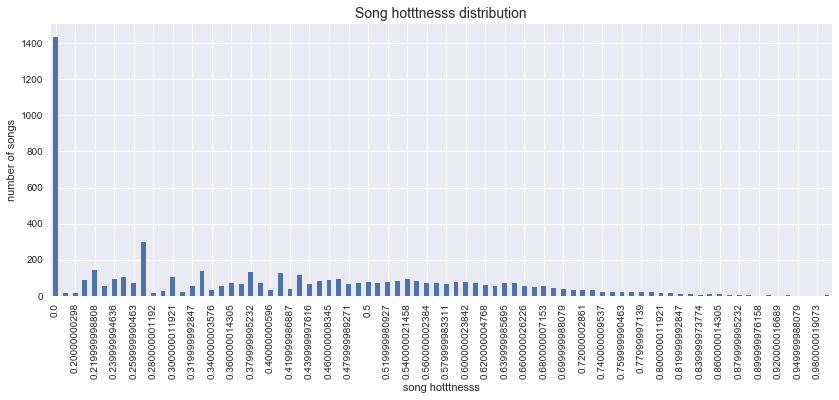

In [22]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_with_step(ax, 2)

In [23]:
data[data['song hotttnesss']==0].count()[0]

1434

From this plot, we see that a really large number of songs have a `song hotttnesss` of 0.
As a result, the bars corresponding to a non-zero `song hotttnesss` tend to be rather squeezed. 
Below, we provide the same barplot, but excluding the 0 values (1434 of them), to see better what happens.

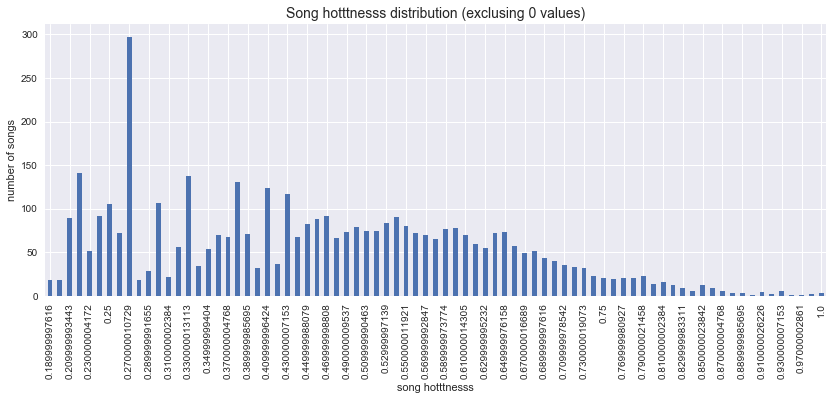

In [24]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data[data['song hotttnesss'] > 0]['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution (excluding 0 values)', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_with_step(ax, 2)

The distribution of the `song hotttness` does not seem to correspond to a particular known distribution.
Most of the songs have an average to low `song hotttnesss`.
This will still be useful for determining what are the features that could make a song unpopular.

#### Release year

In [705]:
describe(data, 'year', True)

year
count  10000.000000
mean     934.704600
std      996.650657
min        0.000000
25%        0.000000
50%        0.000000
75%     2000.000000
max     2010.000000

Like for the `song hotttnesss`, we see that the minimum `year` is 0. Here however, 0 actually stands for `undefined`. In our statistics, we will therefore not include those songs for which a certain feature is undefined, as this would bias the distributions.

In [706]:
describe(data, 'year', False)

year
count  4680.000000
mean   1997.232051
std      11.686691
min    1926.000000
25%    1993.000000
50%    2001.000000
75%    2006.000000
max    2010.000000

Now the earliest `year` is 1926, which indeed appears to  be more realistic. The majority of the songs in the dataset has been released in the last 20 years, although the most recent ones date back to 2010 already. 

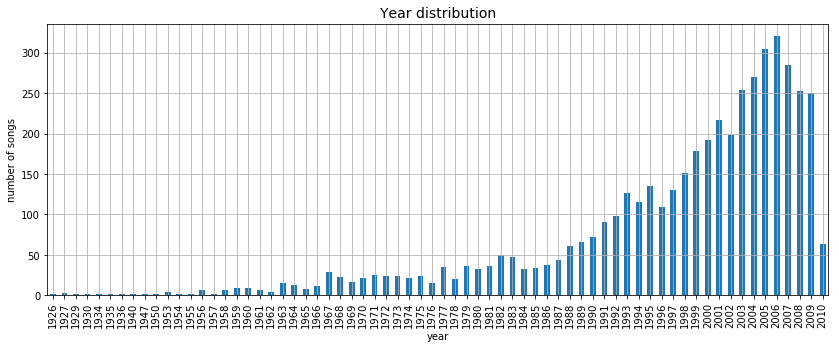

In [707]:
ax = data[data['year'] > 0]['year'].value_counts()\
                                   .sort_index()\
                                   .plot(kind='bar',
                                         grid=True,
                                         figsize=(14, 5));
        
ax.set_title('Year distribution', fontsize=14)
ax.set_xlabel('year')
ax.set_ylabel('number of songs');

Most of the songs we are going to deal with came out in 2000 and later. Hopefully, the ones which were popular in 2011, when the Million Song Dataset was created, remain so to these days. Otherwise, predicting the 2018's best hit might prove more challenging than expected!

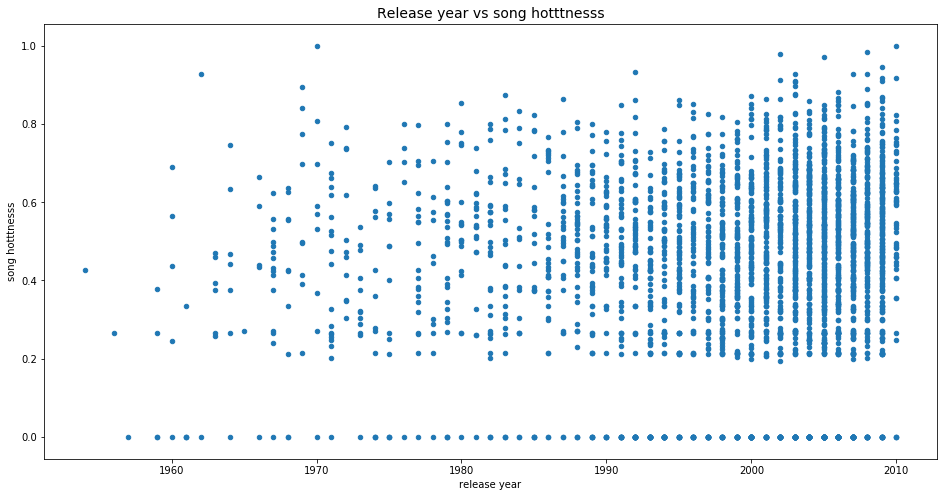

In [708]:
ax = data[(data['year'] != 0) ].plot(kind='scatter', x='year', y='song hotttnesss', figsize=(16,8))
ax.set_title('Release year vs song hotttnesss', fontsize=14)
ax.set_xlabel('release year')
ax.set_ylabel('song hotttnesss');

<div class="alert alert-warning">
Nb: Note the strange gap between 'song hotttness' = 0 and 0.2
<br>After a small investigation, we simply see that over the 26 songs in this range, only 3 have a year not equal to 0.
</div>

In [709]:
data[ (data['song hotttnesss'] > 0) & (data['song hotttnesss'] < 0.2) & (data['year'] != 0)]['song hotttnesss']

70      0.199238
278     0.193858
1009    0.199683
Name: song hotttnesss, dtype: float32

In [713]:
data_valid= data[(data['song hotttnesss'] != 0) & (data['year'] != 0)]
source = ColumnDataSource(data=dict(
    y=data_valid['song hotttnesss'],
    x=data_valid['year'],
    title=data_valid['title'],
    artist=data_valid['artist name'],
    song_hotttnesss=data_valid['song hotttnesss'],
    year=data_valid['year']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),
    ('Year', '@year')
])

hover_scatter_plot(source, hover, 
                   'Song hotttnesss vs release year', 'release year', 'song hotttnesss',
                    None, None, 'horizontal', 'MSD', 900, 600)

Most songs with the highest `song hotttnesss` are among the most recent ones. 
This may be because they are genuinely more popular, or also because the MSD or the MSD subset sampled more songs from these last years.
*Immigrant Song* from Led Zeppelin appears to be an early hit.

#### Artist hotttnesss

In [326]:
data_a_h = round(data[data['artist hotttnesss'] > 0]['artist hotttnesss'], 2).value_counts().sort_index()

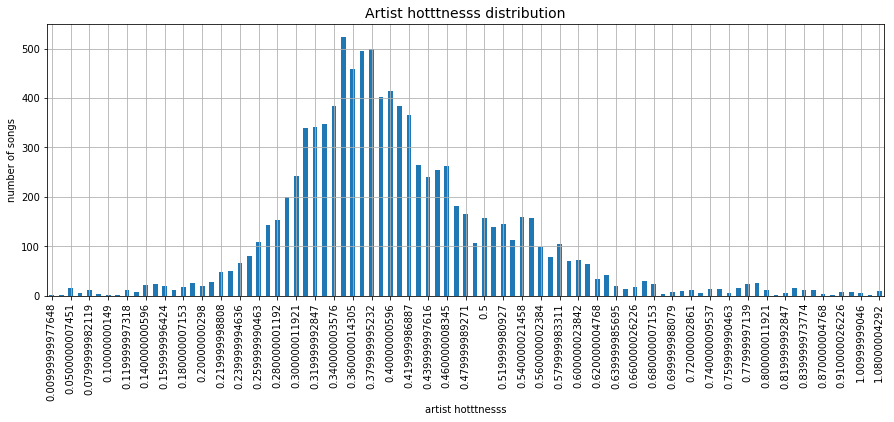

In [328]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = data_a_h.plot(kind='bar',grid=True,figsize=(15, 5));
ax.set_title('Artist hotttnesss distribution', fontsize=14)
ax.set_xlabel('artist hotttnesss')
ax.set_ylabel('number of songs');

set_ticks_with_step(ax, 2)

The distribution of the `artist hotttnesss` appears to be Gaussian-like, except for the fact that it is not really symetric: there are two many values between 0.5 and 0.6 for it to be considered Gaussian.

According to The Echo Nest, these are the artists with the highest `artist hotttnesss` score

In [340]:
threshold = 0.9
data_tmp = data[data['artist hotttnesss'] > threshold].sort_values('artist hotttnesss', ascending=False)[['artist name', 'artist hotttnesss']].drop_duplicates().reset_index(drop=True)
data_tmp

artist name  artist hotttnesss
0                                Kanye West           1.082503
1                  Kanye West / Adam Levine           1.082503
2         Kanye West / Consequence / CamRon           1.082503
3                  Kanye West / Lupe Fiasco           1.082503
4                                 Daft Punk           1.021256
5                           Black Eyed Peas           1.005942
6   Black Eyed Peas / Les Nubians / Mos Def           1.005942
7            Black Eyed Peas / Terry Dexter           1.005942
8                              Taylor Swift           0.922412
9                                  Coldplay           0.916053
10                                  Rihanna           0.908203

However, we see that many of these "artists" are actually collaborations, and that the `artist hotttnesss` does not change for the lead artist. 
For clarity, we only keep the entries about single artists.

In [341]:
# filter out collaborations
data_tmp = data_tmp[~data_tmp['artist name'].str.contains('/')]
data_tmp

artist name  artist hotttnesss
0        Kanye West           1.082503
4         Daft Punk           1.021256
5   Black Eyed Peas           1.005942
8      Taylor Swift           0.922412
9          Coldplay           0.916053
10          Rihanna           0.908203

#### Artist hotttnesss vs song hotttnesss

We now want to verify whether an artist with a low/high `artist hotttnesss` value also has a low/high `song hotttnesss` average.
We expect this to be the case, although it would also be interesting to find see which unpopular artist released popular songs.

In [25]:
# group by 'artist name' and take the average of the 'song hotttnesss's
artist_song_hotttnesss_avg = data.groupby('artist name')['artist name', 'song hotttnesss'].mean()
artist_song_hotttnesss_avg.rename(columns = {'song hotttnesss':'song hotttnesss average'}, inplace=True)
artist_song_hotttnesss_avg.reset_index(inplace=True)
artist_song_hotttnesss_avg.head()

artist name  song hotttnesss average
0                                                !!!                      0.0
1                                         (hed) p.e.                      NaN
2  089 Clique feat. Minnesota Snipe & Skinny Cueball                      0.0
3                           089 Clique feat. Prophet                      0.0
4                        1. Futurologischer Congress                      0.0

In [26]:
print('Number of rows:', len(artist_song_hotttnesss_avg))

Number of rows: 4408


In [27]:
# keep the 'artist name' and the 'artist hotttnesss'
artist_hotttnesss = data[['artist name', 'artist hotttnesss']]
artist_hotttnesss = artist_hotttnesss.drop_duplicates()
artist_hotttnesss.reset_index(drop=True, inplace=True)
artist_hotttnesss.head()

artist name  artist hotttnesss
0            Casual           0.401998
1      The Box Tops           0.417500
2  Sonora Santanera           0.343428
3          Adam Ant           0.454231
4                Go           0.401724

In [28]:
print('Number of rows:', len(artist_hotttnesss))

Number of rows: 4566


Oddly, we see that there are more rows in this dataframe than in the previous one, although the number of artist should be the same in both.
We will therefore take the average of the `artist hotttnesss` for artists with multiple `artist hotttnesss` values.

In [29]:
artist_hotttnesss = pd.DataFrame(artist_hotttnesss.groupby('artist name')['artist hotttnesss'].mean())
artist_hotttnesss.reset_index(inplace=True)
artist_hotttnesss.head()

artist name  artist hotttnesss
0                                                !!!           0.482131
1                                         (hed) p.e.           0.324881
2  089 Clique feat. Minnesota Snipe & Skinny Cueball           0.000000
3                           089 Clique feat. Prophet           0.000000
4                        1. Futurologischer Congress           0.256978

In [30]:
print('Number of rows:', len(artist_hotttnesss))

Number of rows: 4408


The number of rows is now the same in both dataframes. 
The next step consists of merging the two dataframes on the `artist name`.

In [31]:
df = pd.merge(artist_hotttnesss , artist_song_hotttnesss_avg, on='artist name', how='outer')
df.head()

artist name  artist hotttnesss  \
0                                                !!!           0.482131   
1                                         (hed) p.e.           0.324881   
2  089 Clique feat. Minnesota Snipe & Skinny Cueball           0.000000   
3                           089 Clique feat. Prophet           0.000000   
4                        1. Futurologischer Congress           0.256978   

   song hotttnesss average  
0                      0.0  
1                      NaN  
2                      0.0  
3                      0.0  
4                      0.0

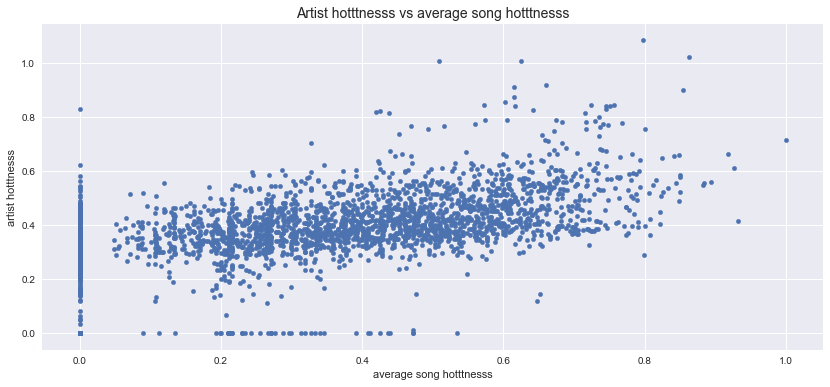

In [32]:
ax = df.plot(kind='scatter', x='song hotttnesss average', y='artist hotttnesss', figsize=(11, 11));
ax.set_title('Artist hotttnesss vs average song hotttnesss', fontsize=14)
ax.set_xlabel('average song hotttnesss')
ax.set_ylabel('artist hotttnesss');

In [35]:
source = ColumnDataSource(data=dict(
    y=df['song hotttnesss average'],
    x=df['artist hotttnesss'],
    artist=df['artist name']
))

hover = HoverTool(tooltips=[
    ('Artist', '@artist')
])

hover_scatter_plot(source, hover, 
                   'average song hotttnesss vs artist hotttnesss', 'average song hotttnesss', 'artist hotttnesss',
                    None, None, 'horizontal', 'MSD', 900, 600)

As expected, there is a visible correlation between the `artist hotttnesss` and the average `song hotttnesss` for a given artist, with the average `song hotttnesss` increasing when the `artist hotttnesss` increases, and vice-versa.

#### Song duration

In [350]:
describe(data, 'duration', False)

duration
count  10000.000000
mean     238.507278
std      114.137314
min        1.044440
25%      176.032196
50%      223.059143
75%      276.375061
max     1819.767700

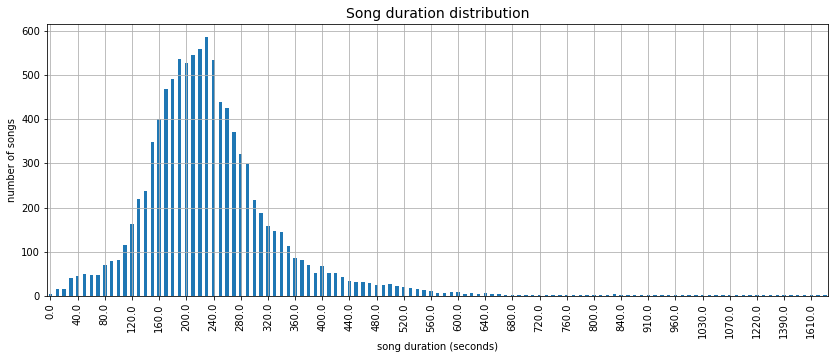

In [351]:
ax = round(data['duration'], -1).value_counts()\
                                .sort_index()\
                                .plot(kind='bar', 
                                      grid=True,
                                      figsize=(14, 5));
        
ax.set_title('Song duration distribution', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('number of songs')
set_ticks_with_step(ax, 4)

The `song duration` may be following a lognormal distribution.
The data is asymetric, with most outliers lying to the right, and some to the left: the most common distributions for this type of data are the lognormal, the Gamma, the Weibull distributions.
Since many natural phenomenons related to some *length* have been observed to follow a lognormal ditribution, then most likely so does the `song duration`.

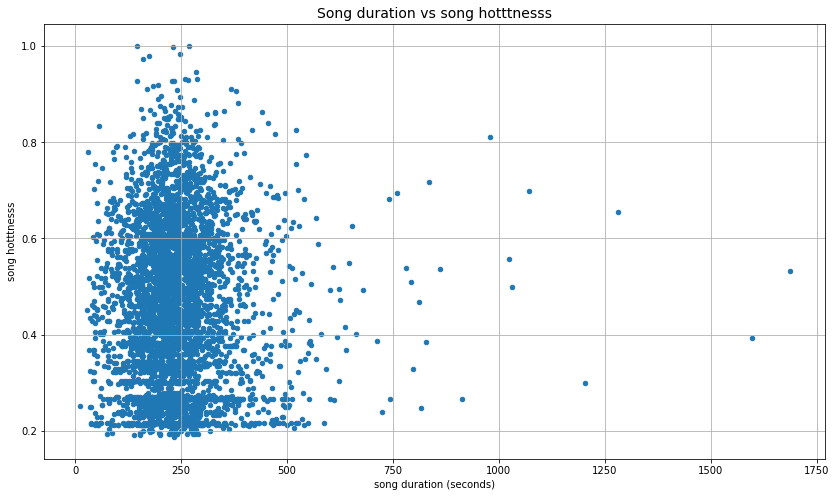

In [685]:
ax = data[data['song hotttnesss'] != 0].plot(kind='scatter', x='duration', y='song hotttnesss', figsize=(14,8), grid=True);
ax.set_title('Song duration vs song hotttnesss', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('song hotttnesss');

In [136]:
data_valid= data[data['song hotttnesss'] != 0]
source = ColumnDataSource(data=dict(
    y=data_valid['song hotttnesss'],
    x=data_valid['duration'],
    title=data_valid['title'],
    artist=data_valid['artist name'],
    song_hotttnesss=data_valid['song hotttnesss'],
    duration=data_valid['duration']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),
    ('Duration', '@duration')
])

hover_scatter_plot(source, hover, 
                   'Song hotttnesss vs song duration', 'song duration (seconds)', 'song hotttnesss',
                    None, None, 'horizontal', 'MSD', 800, 400)

There does not seem to be any particular correlation between the `song hotttnesss` and the `song duration`.
We observe that the most popular songs are neither particularly long or particularly short, but have a `song duration` around the mean.

#### Artist terms

The `artist terms` feature for each song roughly corresponds to the music styles associated to this artist, according to The Echo Nest.
Additionally, there are the `artist terms weight` and the `artist terms freq`, which represent the weight respectively the frequency of each artist term (both between 0.0 and 1.0).

In [170]:
top_list = data['artist terms']
artist_terms_all = [item for sublist in top_list for item in sublist]
artist_terms_distinct = set(artist_terms_all)

print('Total number of artist terms:', len(artist_terms_all))
print('Number of distinct artist terms:', len(artist_terms_distinct))

Total number of artist terms: 266611
Number of distinct artist terms: 3502


In [70]:
serie = pd.Series(artist_terms_all).value_counts()

In [71]:
serie.sort_values(ascending=False).head(10)

rock                6493
pop                 5476
electronic          4453
jazz                3596
united states       3084
hip hop             2926
alternative rock    2753
folk                2598
alternative         2586
soul                2491
dtype: int64

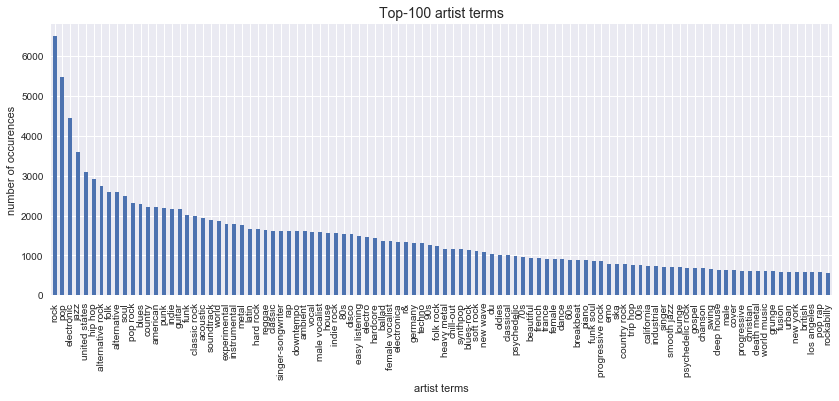

In [72]:
top = 100
ax = serie.sort_values(ascending=False).head(top)\
                                       .plot(kind='bar',
                                             grid=True,
                                             figsize=(14, 5));
    
ax.set_title('Top-' + str(top) + ' artist terms', fontsize=14)
ax.set_xlabel('artist terms')
ax.set_ylabel('number of occurences');

It would seem the songs in the MSD subset (and most likely the MSD dataset in general) are heavily rock and pop oriented.

In [344]:
threshold = 0.9
top_songs = data[data['song hotttnesss'] >= threshold]

In [345]:
top_artist_terms = flatmap(top_songs['artist terms'])
top_artist_terms_weight = flatmap(top_songs['artist terms weight'])

In [346]:
list_tuples = list(zip(top_artist_terms, top_artist_terms_weight))

In [347]:
groups = defaultdict(list)

#group by term
for item in list_tuples:
    groups[item[0]].append(item[1])

#compute the mean
for item in groups.items():
    groups[item[0]] = (np.mean(item[1]), np.std(item[1]))
                       

In [348]:
top_artist_terms_sorted = sorted(groups.items(), key=lambda value: value[1][0], reverse=True)

In [349]:
df = pd.DataFrame()
df['artist terms'] = [item[0] for item in top_artist_terms_sorted]
df['mean artist terms weight'] = [item[1][0] for item in top_artist_terms_sorted]
df['std artist terms weight'] = [item[1][1] for item in top_artist_terms_sorted]
df.head(20)

artist terms  mean artist terms weight  std artist terms weight
0               teen pop                  1.000000                 0.000000
1               rap rock                  1.000000                 0.000000
2      experimental rock                  1.000000                 0.000000
3        dirty south rap                  1.000000                 0.000000
4               jazz rap                  1.000000                 0.000000
5             piano rock                  0.999826                 0.000000
6            post-grunge                  0.999634                 0.000000
7               pop punk                  0.985320                 0.014680
8              indie pop                  0.983775                 0.000000
9              soul jazz                  0.973970                 0.000000
10            bossa nova                  0.967757                 0.000000
11             funk rock                  0.961575                 0.000000
12  alternative pop rock                  0.957946                 0.000000
13     alternative metal                  0.954073                 0.045927
14            all-female                  0.953285                 0.000000
15            blues-rock                  0.951414                 0.051199
16               europop                  0.941218                 0.000000
17             post rock                  0.939057                 0.011807
18              neo soul                  0.938690                 0.043900
19             jazz funk                  0.933124                 0.066876

<function matplotlib.pyplot.tight_layout>

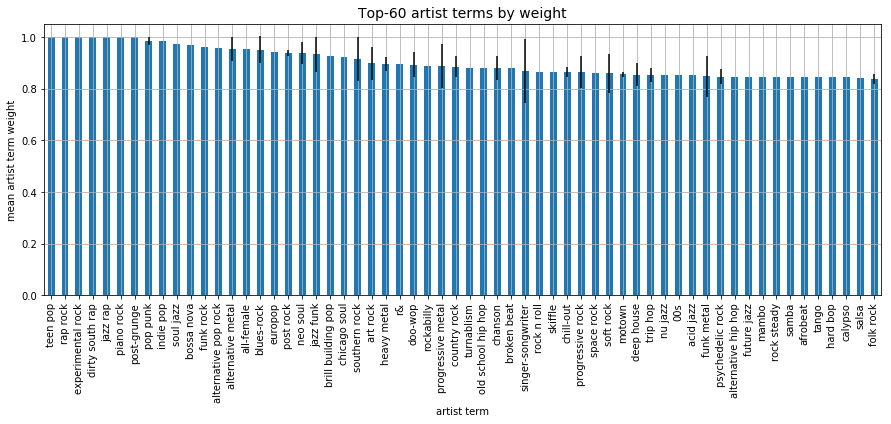

In [687]:
top = 60
error = df.head(top)['std artist terms weight']
ax = df.head(top)['mean artist terms weight'].plot(kind='bar', yerr=error, grid=True, figsize=(15, 5));

ax.set_title('Top-' + str(top) + ' artist terms by weight', fontsize=14)
ax.set_xlabel('artist term')
ax.set_ylabel('mean artist term weight')
ax.set_xticklabels(df['artist terms'])
plt.tight_layout;

In [242]:
#consider regrouping artist terms into less groups
#"rap rock", "funk rock", funk rap", "jazz funk", "jazz rap", "jazz rock" ...........

For now, we did not analyse the `artist mbtags`, since compared to the `artist terms`, many songs were at that time not evaluated.

#### Beats

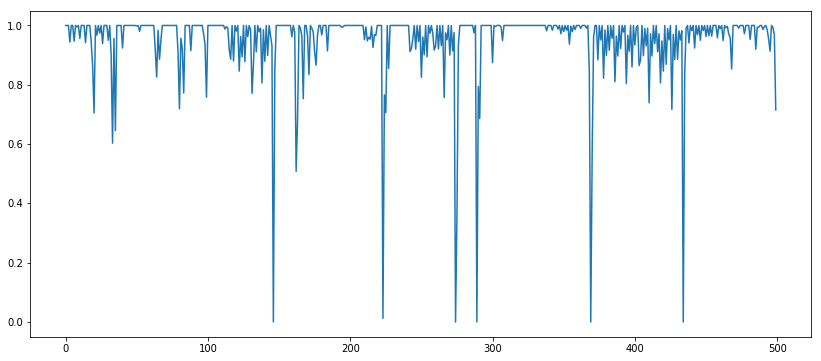

In [688]:
idx = 9
plt.figure(figsize=(14, 6))
serie = data['beats confidence'][idx]
plt.plot(np.arange(0,len(serie)), serie);

#### Key
There is 24 of them. Twelve are Majors and the all have what we call a minor relative. The major keys are in order :
$$ C - G - D - A - E - B - F\# - C\# - A\flat - E\flat - B\flat - F $$
as we can see in this picture :

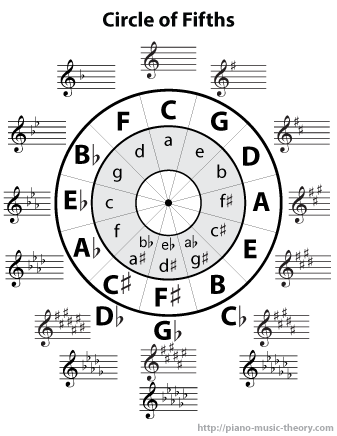

In [692]:
from IPython.display import Image
Image("img/fifths.png")

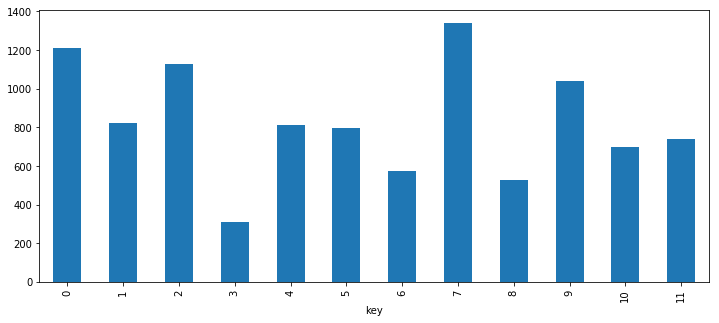

In [693]:
data_key = data.groupby('key')['key'].count()
data_key.index = data_key.index.astype(int)
data_key.sort_index().plot(kind='bar',figsize=(12,5))

We checked (manually...with the help of "findsongtempo.com") these song to get the matching between the key in data and the real key :

In [695]:
dd = pd.DataFrame()
for key in range(12) :
     dd = dd.append((data[(data['key'] == str(key)) 
      & (data['artist hotttnesss'] > 0.6)
      & (data['key confidence'] > 0.84)][['artist name', 'title','key confidence', 'key']]).head(1))
dd

artist name                              title  \
660               Radiohead        Subterranean Homesick Alien   
1059            Lloyd Banks                   South Side Story   
1427           Jack Johnson                 You And Your Heart   
247                      U2              Kite Live from Sydney   
507                 Shakira                       Pienso En Ti   
2559                 Eminem                          Beautiful   
9226  Bon Jovi / Ray Davies                   Celluloid Heroes   
108         Martina McBride             I Cant Stop Loving You   
3336       Enrique Iglesias  Do You Know? (The Ping Pong Song)   
3097       Enrique Iglesias                  Si Juras Regresar   
2899         Beyonc\xc3\xa9     Irreplaceable (Irreemplazable)   
4695         Beyonc\xc3\xa9   Single Ladies (Put A Ring On It)   

      key confidence key  
660            0.847   0  
1059           1.000   1  
1427           1.000   2  
247            0.878   3  
507            0.970   4  
2559           1.000   5  
9226           0.896   6  
108            0.960   7  
3336           0.918   8  
3097           0.930   9  
2899           0.852  10  
4695           0.847  11

Results by exploration :

| Key number | Key |
|:-----:|-----|-|
|0|C| |
|1|C$\sharp$|
|2|D| 
|3|E$\flat$| 
|4|E| 
|5|F| 
|6|?| 
|7|G| 
|8|A$\flat$| 
|9|A| 
|10|B$\flat$| 
|11| ?| 

We found 2 inccorect/unprecise results. But we can see that the key isn't the index in the fifths cycle, but simply the 12 half tone in the music scale.

In [697]:
key_to_explore = 5
(data[(data['key'] == str(key_to_explore)) 
      & (data['artist hotttnesss'] > 0.6)
      & (data['key confidence'] > 0.8)][['artist name', 'title','key confidence']]).head(1)

artist name      title  key confidence
2559      Eminem  Beautiful             1.0

By further analysis, it is important that we can select the key of our song. 

#### Non-evaluated features

Unfortunately, some features such as `energy` or `danceability` happen to not have been evaluated for any of the songs in the Million Song Dataset subset, so that we were not able to use them in this first analysis.

The whole Million Song Dataset most likely contains a few songs were these features have been evaluated though.

In [240]:
describe(data, 'energy', True)

energy
count  10000.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0

In [241]:
describe(data, 'danceability', True)

danceability
count       10000.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0

#### Applying the analysis to the Million Song Dataset (see milestone 3)

Once we move to the whole Million Song Dataset, we will obviously not be saving 280 GB to .csv files.

What we will do instead is collect the data from the cluster using the `GetData.py` Python script.
In this script, we will be dropping the features we are not interested in, which will reduce the size of the data per song significantly (e.g. `segments timbre`, `segment pitches`, ..., if we do not find a use for these feature in our analysis).

<div class="lev2"><a href="#Table-of-Contents">Back to Top</a></div>
## Million Song Dataset 
#### (milestone 3)

After having explored the Million Song Dataset subset, we decided to drop a number a features, in particular the time series describing the audio of the song. 
Instead, we focus on a particular set of features, namely the song duration, the artist's country of origin, the music genre and the song lyrics.
One advantage is also that it significantly reduces the size of the data, thus making it easier to handle, as it can be kept locally (we go from 280 GB to 193 MB)

The features we kept are the followings:
* Song-related features
  * `song id`
  * `track id`
  * `title`
  * `year`
  * `duration`
  * `song hotttnesss`
  * `danceability`
  * `energy`
* Artist-related features
  * `artist id`
  * `artist name`
  * `artist terms`
  * `artist terms weight`
  * `artist latitude`
  * `artist longitude`
  * `artist location`
  * `artist hotttnesss`
  
whereas the features we dropped are:
  * `analysis sample rate`
  * `artist 7digitalid`
  * `artist familiarity`
  * `artist mbid`
  * `artist mbtags`
  * `artist mbtags count`
  * `artist playmeid`
  * `artist terms freq`
  * `audio md5`
  * `bars confidence`
  * `bars start`
  * `beats confidence`
  * `beats start`
  * `end of fade in`
  * `index` 
  * `key`
  * `key confidence`
  * `loudness`
  * `mode`
  * `mode confidence`
  * `num songs`
  * `release`
  * `release 7digitalid`
  * `sections confidence`
  * `sections start`
  * `segments confidence`
  * `segments start`
  * `segments loudness max`
  * `segments loudness max time`
  * `segments loudness start`
  * `segments pitches`
  * `segments start`
  * `segments timbre`
  * `similar artists`
  * `start of fade out`
  * `tatums confidence`
  * `tatums start`
  * `tempo`
  * `time signature`
  * `time signature confidence`
  * `track 7digitalid`

In [97]:
path_msd = './data/msd/'

In [99]:
filename = 'A-Z-ADA.json'
with open(path_msd+filename, 'r') as file :
    lines = file.readlines()

print('Number of lines:', len(lines))

Number of lines: 159431


In [100]:
start = 400000
end = 507779
with open(path_msd+'msd_part_3.json', 'w') as file:
    for line in lines[start:end]:
        file.write(line)

In [102]:
filename = 'msd_filtered_part1.json'
data_msd = pd.read_json(path_msd + filename, orient='split', encoding='utf-8-sig')
data_msd.head(1)

year  artist latitude  artist longitude  artist hotttnesss  \
0  1984              NaN               NaN           0.332276   

            artist id             song id       title  \
0  AR8ZCNI1187B9A069B  SOIAZJW12AB01853F1  Pink World   

                                        artist terms  \
0  [new wave, progressive rock, space rock, eurod...   

                                 artist terms weight  song hotttnesss  \
0  [1.0, 0.9869619197460081, 0.983064531867962, 0...         0.265861   

   danceability   duration  energy       artist name            track id  \
0             0  269.81832       0  Planet P Project  TRAAARJ128F9320760   

  artist location  
0

In [103]:
data = data_msd.copy()
print('Number of songs:', len(data))

Number of songs: 159430


In addition to keep only a certain set of features, we also drop songs for which the `song hotttnesss` is not defined (i.e. is `NaN`), since throughout the whole analysis, we almost always compare a feature of a song against the `song hotttnesss`.

This then reduces the number of songs from 1 000 000 to 159 430.

*+ A - L*

In [73]:
#single values
#data['title'] = clean_string_column(data['title'])
#data['artist name'] = clean_string_column(data['artist name'])
#data['artist id'] = clean_string_column(data['artist id'])
#data['artist location'] = clean_string_column(data['artist location'])
#data['track id'] = clean_string_column(data['track id'])

#arrays
#data['artist terms'] = clean_string_column(data['artist terms'])

### Overview

Just like we did for the Million Song Dataset subset of 10 000 songs, we now give a brief overview of this larger Million Song Dataset subset.
In particular, we plot the distribution of the song release year and the song hotttnesss.

#### Release year

In [71]:
describe(data, 'year', False)

year
count  159430.000000
mean     1999.548234
std         9.740172
min      1925.000000
25%      1996.000000
50%      2003.000000
75%      2006.000000
max      2011.000000

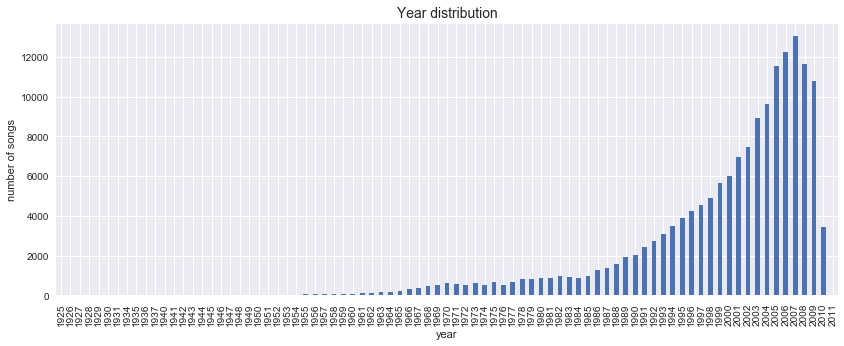

In [74]:
ax = data[data['year'] > 0]['year'].value_counts()\
                                   .sort_index()\
                                   .plot(kind='bar',
                                         grid=True,
                                         figsize=(14, 5));
        
ax.set_title('Year distribution', fontsize=14)
ax.set_xlabel('year')
ax.set_ylabel('number of songs');

plt.savefig('./report/images/release_year_distribution.png', dpi=100)

The release years range from 1925 to 2011.
While this is not visible on the plot, there is exactly one song for the year 2011, although the MSD was put together in 2010 (but released in 2011).
The distribution is not uniform at all, with most collected songs from between 1995 and 2010, and very few previously.

This is not particularly surprising, as it is easier to gather data for recent songs, and also makes the dataset more relevant, since it is supposed to be contemporary.
However, it also suggests caution when dealing with the songs on the dataset dating back to the 90's and before, as there are really very few of them.

In [76]:
year = 2011
print('Number of songs released in', year, ':', len(data[data['year'] == year]))

Number of songs released in 2011 : 1


#### Song hotttnesss distribution

The `song hotttnesss` is the feature which serves as our metric for evaluating the popularity, or the "hotttnesss", of a song.

In [124]:
describe(data, 'song hotttnesss', True)

song hotttnesss
count    159430.000000
mean          0.430871
std           0.214409
min           0.000000
25%           0.304170
50%           0.459158
75%           0.581318
max           1.000000

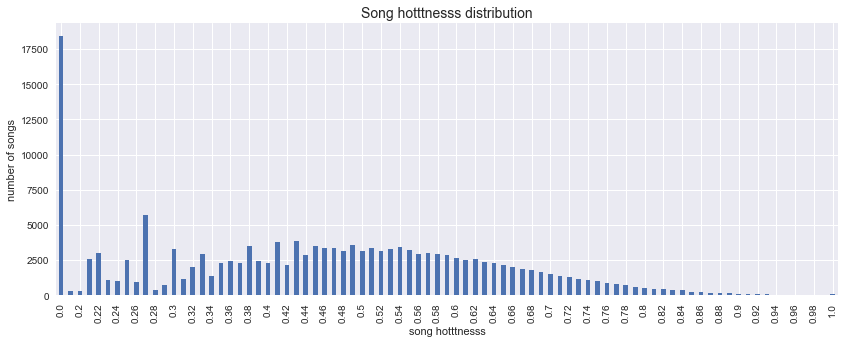

In [119]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_with_step(ax, 2)

The `song hotttnesss` ranges from 0.0 to 1.0, but we see that there are still as many zero values for the `song hotttnesss` in the larger subset. 
This would many of the songs are actually not "hot" at all - not even a bit, which is surprising, since we would expect at least one user to rate a song positively.
A rating of 0.0 suggests that each user who rated the song explicitely went through the trouble of setting ts `song hotttnesss` to 0.0. 
Usually, users tend to rate songs they actually like, not the contrary.

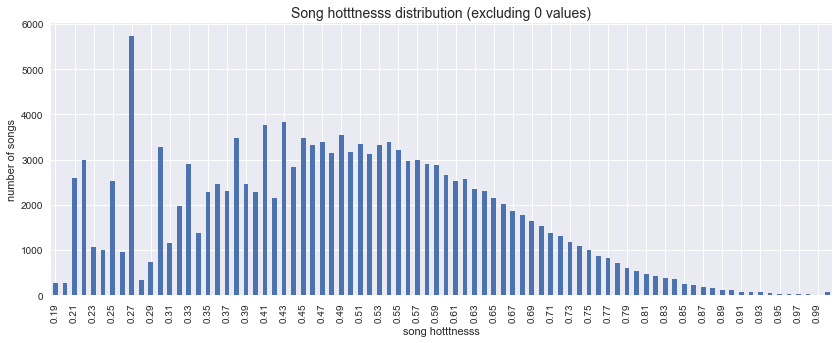

In [137]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data[data['song hotttnesss'] > 0]['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution (excluding 0 values)', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_with_step(ax, 2)

plt.savefig('./report/images/song_hotttnesss_distribution.png', dpi=100)

When removing the zero values from the plot, we get a better insight for the other values.
In overall, the `song hotttnesss` distribution seems less fragemented than for in the MSD subset.

What immediately stands out is the uneveness of the resulting distribution. 
The right part of the distribution is very smooth, the left part not at all.
The reason for the peaks around 0.27 or 0.22 is not very clear either.

#### Geographic repartition
In this section, we give a geographic overview of the origin of the songs in the MSD. 

To this end, we use the corresponding `artist latitude` and the `artist longitude` as the "geographic coordinates" of a song.
However, we are not interested in the exact geographic coordinates, but only the country of origin of the song. 
We will therefore perform a reverse geolocalization query on each coordinate in order to recover the corresponding country.

In the dataset, songs also have a `artist location` field which can be used to assign it a geographic location.

In [78]:
path_geolocation = './data/geolocation/'

In a first step, we collect all valid coordinates from the dataset (i.e. all coordinates which are not `NaN`).
Songs with the same artist are likely to have the same `artist latitude` and `artist longitude` as well. Since we do not want to query those coordinates twice, we also drop all duplicates coordinates.

Because we do not want to perform the reverse query everytime the code needs to be run, we also save all coordinates with the corresponding country to a file.

In [79]:
# filter out NaN coordinates and drop duplicates
valid_coordinates = data[['artist latitude', 'artist longitude']].dropna().drop_duplicates()

# save all coordinates in a file
valid_coordinates.to_csv(path_geolocation+'coordinates_msd.txt', sep=',', encoding='utf-8', header=None, index=False)

# make a list of coordinates
valid_coordinates =  list(zip(valid_coordinates['artist latitude'], valid_coordinates['artist longitude']))

print('Number of (distinct) valid coordinates (i.e. not NaN):', len(list(set(valid_coordinates))))

Number of (distinct) valid coordinates (i.e. not NaN): 1875


In [82]:
print('Number of songs with valid coordinates:', len(data[~data['artist longitude'].isnull()]))

Number of songs with valid coordinates: 58277


Unfortunately, the geographic coordinates are defined for only 58 227 songs, that is for roughly 36% of the songs in our dataset.
We do not know why certain songs do not have geographic coordinates assigned to them: it may be because the team which collected the data simply omitted them for some songs (unknown, uncertain, not relevant, ...), because they are generally unknown, or maybe because of some other reason.

However, this means that we cannot be sure that the sample of songs with geographic coordinates is actually representative for the whole dataset. 
Therefore, it may be the case that the observations we are making do not apply for the whole dataset.

In [86]:
# returns a list of coordinates from the file with the given <filename>
# estarts from line number <start> (included) and ends at line number <end> (excluded)
def get_next_coordinates(filename, start, end):
    coordinates_list = []
    with open(path_geolocation+filename) as f:
        for line in islice(f, start, end):
            line = line.rstrip('\n')
            coordinates = (float(line.split(',')[0]), float(line.split(',')[1]))
            coordinates_list.append(coordinates)
    return coordinates_list

In [87]:
# returns a list of coordinates from the file with the given <filename>
# eventually skips the lines with the line numbers given in <skiplines>
def get_coordinates(filename, skiplines):
    coordinates_list = []
    i = 1
    with open(path_geolocation+filename) as f:
        for line in f:
            if i not in skiplines:
                line = line.rstrip('\n')
                coordinates = (float(line.split(',')[0]), float(line.split(',')[1]))
                coordinates_list.append(coordinates)
            i+=1
    return coordinates_list

In [88]:
# performs a reverse geolocalization query on the given list of coordinates
# writes the result (latitude, longitude, coutry, city) in the file with the given <filename>
def query_reverse_geolocation(coordinates, filename):
    done = False
    
    while(not done):
        try:
            results = Geocoder.reverse_geocode(coordinates[0], coordinates[1])
            print(results.coordinates, ' ', results.country, ' ', results.city)
            
            # precision problem between queried coordinates and returned coordinates (<results.coordinates>)
            # --> do not store <results.coordinates>, but the queries coordinates
            country = results.country
            city = results.city

            with open(path_geolocation+filename, 'ab') as myfile:
                value = str(coordinates[0]) + '\t' + str(coordinates[1]) + '\t' + str(country) + '\t' + str(city) + '\n'
                myfile.write(value.encode('utf-8'))

            done = True
        except GeocoderError:
            print('Error OVER_QUERY_LIMIT' + ' -- try again later')
            time.sleep(4) # delay in seconds

We now reverse-query the country and the city of each pair of coordinates in the dataset, and save the result to file.

*note: skip this code cell if the 'coordinates_map.txt' file has already been built
(this code needs not to be run again if all coordinates have already been queried and the file has been built)*

In [89]:
#note: some incorrect coordinates, so skip these (line number in .csv file)
#skiplines = [411, 569] # in MSD subset
skiplines = [197, 779] # in MSD
start = 0
end = 4

filename_from = 'coordinates_msd.txt' # read from this file
filename_to = 'coordinates_map_msd_tmp.txt' # write to this file

coordinates_list = get_next_coordinates(filename_from, start, end)

i = start
for coordinates in coordinates_list:
    print('Querying coordinates #', i, '...')
    query_reverse_geolocation(coordinates,filename_to)
    i += 1

Querying coordinates # 0 ...
(41.8841505, -87.63234659999999)   United States   Chicago
Querying coordinates # 1 ...
(37.7791674, -122.4199917)   United States   San Francisco
Querying coordinates # 2 ...
(45.5119023, -122.6755269)   United States   Portland
Querying coordinates # 3 ...
(51.5063171, -0.127155)   United Kingdom   London


When all coordinates have been reverse-queried and the result saved to file, it is straightforward to load the content of the file into a dataframe.

In [90]:
filename = 'coordinates_map_msd.txt'
df_coordinates = pd.read_csv(path_geolocation+filename, sep='\t', header=None)
df_coordinates.columns = ['latitude', 'longitude', 'country', 'city']
df_coordinates.head()

latitude  longitude         country           city
0  41.88415  -87.63241   United States        Chicago
1  37.77916 -122.42005   United States  San Francisco
2  45.51179 -122.67563   United States       Portland
3  51.50632   -0.12714  United Kingdom         London
4  37.54703 -122.31483   United States      San Mateo

We can now map the `artist latitude` and `artist longitude` in the original dataframe to the corresponding country, by merging both dataframes on the latitude and longitude pairs.

In [91]:
data_geo = data[['track id', 'artist latitude', 'artist longitude', 'song hotttnesss']].dropna()

data_geo = pd.merge(data_geo, df_coordinates, how='inner',
                    left_on=['artist latitude', 'artist longitude'],
                    right_on=['latitude', 'longitude'])

data_geo = data_geo.drop(['artist longitude', 'artist latitude'], axis=1)
print('Number of entries matched:', len(data_geo))
data_geo.head()

Number of entries matched: 35106


track id  song hotttnesss  latitude  longitude        country  \
0  TRAAAQO12903CD8E1C         0.254279  41.88415  -87.63241  United States   
1  TRAACPE128F421C1B9         0.413740  41.88415  -87.63241  United States   
2  TRAAIII128F427D5D8         0.617366  41.88415  -87.63241  United States   
3  TRAAKFF128F42B69BD         0.360371  41.88415  -87.63241  United States   
4  TRAAOJS128F425FE86         0.000000  41.88415  -87.63241  United States   

      city  
0  Chicago  
1  Chicago  
2  Chicago  
3  Chicago  
4  Chicago

The data cannot be displayed as such on a map; we first need to map the country names to an ISO code, since this is what topojson files usually use.
Beforehand, we therefore built a .csv file containing all country names with the corresponding ISO alpha-2 code, ISO alpha-3 code, and ISO numeric code.

In [92]:
country_codes = pd.read_csv(path_geolocation+'country_codes.csv', sep=',', encoding='latin-1')

# convert the ISO numeric code to string and pad it with 3 zeros (convention)
country_codes['iso numeric code'] = [str(s).zfill(3) for s in country_codes['iso numeric code']]

# convert all fields to string and remove potential blank spaces
country_codes['country'] = [str(s).strip() for s in country_codes['country']]
country_codes['iso alpha 2 code'] = [str(s).strip() for s in country_codes['iso alpha 2 code']]
country_codes['iso alpha 3 code'] = [str(s).strip() for s in country_codes['iso alpha 3 code']]
country_codes['iso numeric code'] = [str(s).strip() for s in country_codes['iso numeric code']]

country_codes.head()

country iso alpha 2 code iso alpha 3 code iso numeric code
0     Afghanistan               AF              AFG              004
1   Aland Islands               AX              ALA              248
2         Albania               AL              ALB              008
3         Algeria               DZ              DZA              012
4  American Samoa               AS              ASM              016

The topojson we will use comes from https://github.com/deldersveld/topojson/blob/master/world-countries-sans-antarctica.json, and identifies countries by their ISO alpha-3 code.

In [93]:
state_geo_path = r'./data/geolocation/world_topo.json'

with open(state_geo_path) as json_data:
    world_topojson = json.load(json_data)

In [94]:
song_count_per_country = data_geo.groupby('country').size().to_frame('count').reset_index() #sort_values(ascending=False)
song_count_per_country = pd.merge(song_count_per_country , country_codes, how='left',
                    left_on=['country'],
                    right_on=['country'])
song_count_per_country.sort_values(by='count', ascending=True).head(10)

country  count iso alpha 2 code iso alpha 3 code  \
0             Afghanistan      1               AF              AFG   
8                 Bolivia      1               BO              BOL   
15                  China      1               CN              CHN   
43                Namibia      2              nan              NAM   
38                 Latvia      2               LV              LVA   
11               Bulgaria      2               BG              BGR   
67                 Taiwan      3              NaN              NaN   
56                Romania      3               RO              ROU   
55  Republic of the Congo      3              NaN              NaN   
51            Philippines      3               PH              PHL   

   iso numeric code  
0               004  
8               068  
15              156  
43              516  
38              428  
11              100  
67              NaN  
56              642  
55              NaN  
51              608

In [95]:
lausanne_coord = [46.519962, 6.633597]
map_world = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=2)

scale = list(song_count_per_country['count'].quantile([x * 1/5 for x in range(1, 5)]).values)
scale = [min(song_count_per_country['count'])] + scale + [max(song_count_per_country['count'])]
print('scale:', [int(x) for x in scale])

map_world.choropleth(geo_data=world_topojson, 
                    data=song_count_per_country,
                    columns=['iso alpha 3 code', 'count'],
                    threshold_scale=scale,
                    key_on='id',
                    topojson='objects.countries1',
                    fill_color='BuPu', fill_opacity=0.6, line_opacity=0.2,
                    legend_name='Song repartition')

map_world

scale: [1, 6, 18, 31, 212, 20376]


**Observations:**

* In overall, the songs mostly come from the western countries
* The immense majority of the songs though seems to come from the United States
* Latin America is relatively well covered, but the number of songs is not comparable to North America
* There are only few songs from a few countries of Africa or Asia
* Two countries nonetheless stand out, and visibly managed to get their songs sampled in the MSD:
  * Japan (probably because it successfully exported its culture to the western countries)
  * Australia (probably because it is historically closely related to the Anglo-Celtic Western culture) 
     
To confirm our findings, we plot the fraction of songs which comes from each country in a bar plot.

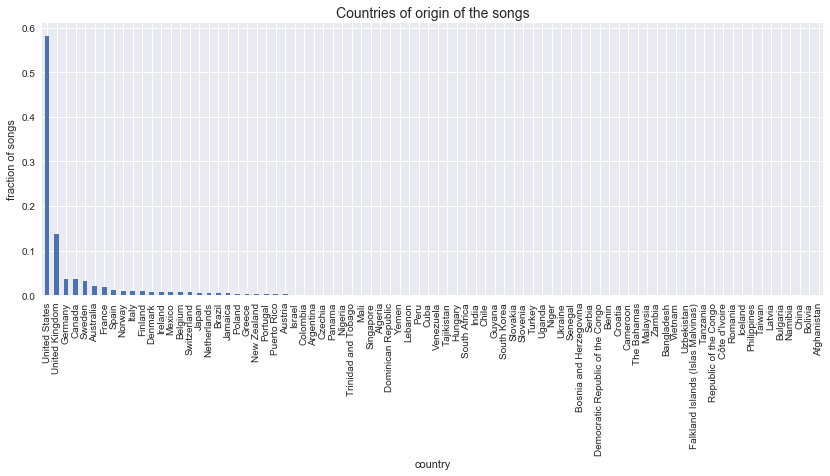

In [96]:
ax = (song_count_per_country['count']/song_count_per_country['count'].sum()).\
                                                sort_values(ascending=False).\
                                                plot(kind='bar', figsize=(14,5))

ax.set_title('Countries of origin of the songs', fontsize=14)
ax.set_xlabel('country')
ax.set_ylabel('fraction of songs')

ax.set_xticklabels(song_count_per_country.sort_values(by='count', ascending=False)['country']);

We now see even more clearly that most of the songs - almost 60% in fact - come from the United States.
Slightly more than 10% have their origin in the United Kingdom. 
It does not escape our notice that the top-2 countries are Anglo-Saxon countries.

There is always he possiblity that the songs for which no geographic coordinates are available all come from countries which are here underrepresented, or not at all.
What happened most likely however is that the songs in the MSD were selected with a heavy emphasis on artist from these countries.

<div class="lev2"><a href="#Table-of-Contents">Back to Top</a></div>

### Where should the artist come from?
We will now determine whether there is a relationship between the geopgrahic location of the song and its `song hotttnesss`. To this end, we first compute the average `song hotttnesss` per country.

In [97]:
song_hotttnesss_avg_per_country = data_geo.groupby('country')['country', 'song hotttnesss'].mean().reset_index() #sort_values(ascending=False)
song_hotttnesss_avg_per_country = pd.merge(song_hotttnesss_avg_per_country , country_codes, how='left',
                    left_on=['country'],
                    right_on=['country'])

song_hotttnesss_avg_per_country.head()

country  song hotttnesss iso alpha 2 code iso alpha 3 code  \
0  Afghanistan         0.724092               AF              AFG   
1      Algeria         0.413942               DZ              DZA   
2    Argentina         0.343779               AR              ARG   
3    Australia         0.417387               AU              AUS   
4      Austria         0.372608               AT              AUT   

  iso numeric code  
0              004  
1              012  
2              032  
3              036  
4              040

In [99]:
def draw_map(song_hotttnesss_avg_per_country):
    lausanne_coord = [46.519962, 6.633597]
    map_world = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=2)

    scale = list(song_hotttnesss_avg_per_country['song hotttnesss'].quantile([x * 1/5 for x in range(1, 5)]).values)
    scale = [min(song_hotttnesss_avg_per_country['song hotttnesss'])] + scale + [max(song_hotttnesss_avg_per_country['song hotttnesss'])]
    print('scale:', [round(x, 2) for x in scale])
    
    map_world.choropleth(geo_data=world_topojson, 
                        data=song_hotttnesss_avg_per_country,
                        columns=['iso alpha 3 code', 'song hotttnesss'],
                        threshold_scale=scale,
                        key_on='id',
                        topojson='objects.countries1',
                        fill_color='YlOrBr', fill_opacity=0.6, line_opacity=0.2,
                        legend_name='Average song hotttnesss')

    return map_world
    
draw_map(song_hotttnesss_avg_per_country)

scale: [0.0, 0.31, 0.38, 0.44, 0.48999999999999999, 0.71999999999999997]


**Observations:**

* Some countries particularly stand out, like Afghanistan or Mali for instance, despite the fact that only few songs where recorded for them (see previous map)
* The United States, Canada, and Western Europe, which together regroup the most songs, display an average `song hotttnesss` average, most likely due to large variations in songs

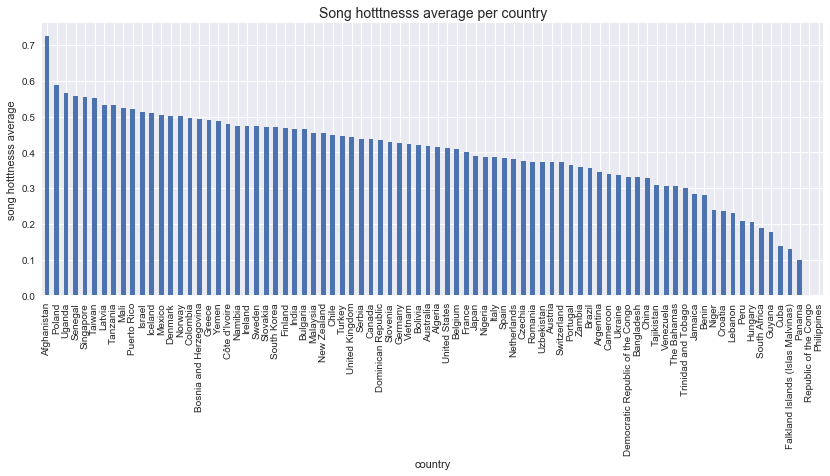

In [28]:
ax = (song_hotttnesss_avg_per_country['song hotttnesss']).\
                                                sort_values(ascending=False).\
                                                plot(kind='bar', figsize=(14,5))

ax.set_title('Song hotttnesss average per country', fontsize=14)
ax.set_xlabel('country')
ax.set_ylabel('song hotttnesss average')

ax.set_xticklabels(song_hotttnesss_avg_per_country.sort_values(by='song hotttnesss', ascending=False)['country']);

We mapped songs to their country of origin using the `artist latitude` and the `artist longitude`, but it turns out only one, two, sometimes three songs actually belong to a given country.
As a consequence, computing the mean `song hotttnesss` for these countries does not really provide representative results.

For instance, Afghanistan ranks top for the mean `song hotttnesss` per country. 
In the dataset though, there is only a single song for Afghanistan.
By contrast, the United States records 20 376 songs in total (with valid geographic coordinates) - comparing the mean `song hotttnesss` between these two countries would be out of proportion.

In [104]:
print('Number of songs for Afganhistan:', len(data_geo[data_geo['country'] == 'Afghanistan']))
print('Number of songs for the United States:', len(data_geo[data_geo['country'] == 'United States']))

Number of songs for Afganhistan: 1
Number of songs for the United States: 20376


For this statistic, we therefore only keep entries whose associated country has "enough" recorded songs.

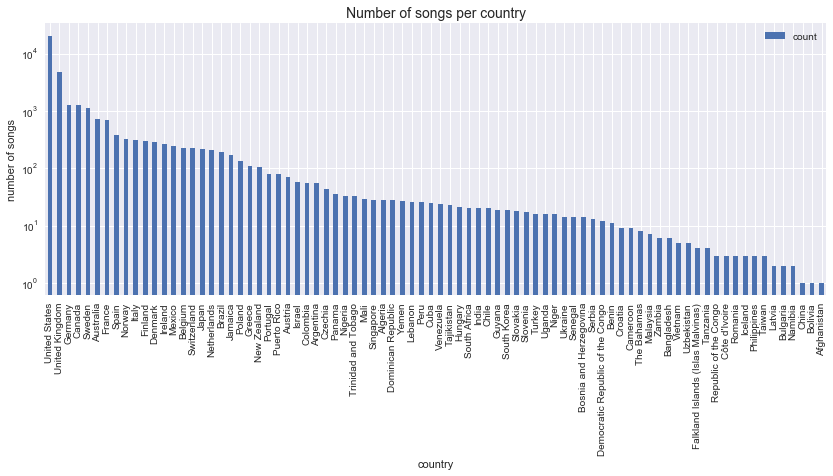

In [106]:
df = data_geo.groupby('country').size().to_frame('count').reset_index()

ax = df.sort_values(by='count', ascending=False).plot(kind='bar', figsize=(14,5), logy=True)

ax.set_title('Number of songs per country', fontsize=14)
ax.set_xlabel('country')
ax.set_ylabel('number of songs')

ax.set_xticklabels(df.sort_values(by='count', ascending=False)['country']);

In [107]:
threshold = 100
keep_countries = df[df['count'] >= threshold]['country'].tolist()
print('Number of countries selected:', len(keep_countries), 'out of', len(df))

Number of countries selected: 23 out of 82


In [108]:
song_hotttnesss_avg_per_country = data_geo[(data_geo['country'].isin(keep_countries)) 
                                         & (data_geo['song hotttnesss'] > 0.0)].\
                                        groupby('country')['country', 'song hotttnesss'].\
                                        mean().\
                                        sort_values(by='song hotttnesss', ascending=False).\
                                        reset_index()
song_hotttnesss_avg_per_country = pd.merge(song_hotttnesss_avg_per_country , country_codes, how='left',
                    left_on=['country'],
                    right_on=['country'])
song_hotttnesss_avg_per_country.head(10)

country  song hotttnesss iso alpha 2 code iso alpha 3 code  \
0          Poland         0.588904               PL              POL   
1         Denmark         0.544802               DK              DNK   
2          Greece         0.528571               GR              GRC   
3          Mexico         0.527520               MX              MEX   
4          Sweden         0.518744               SE              SWE   
5          Norway         0.518241               NO              NOR   
6         Ireland         0.516541               IE              IRL   
7         Finland         0.491109               FI              FIN   
8          Canada         0.489833               CA              CAN   
9  United Kingdom         0.485735               GB              GBR   

  iso numeric code  
0              616  
1              208  
2              300  
3              484  
4              752  
5              578  
6              372  
7              246  
8              124  
9              826

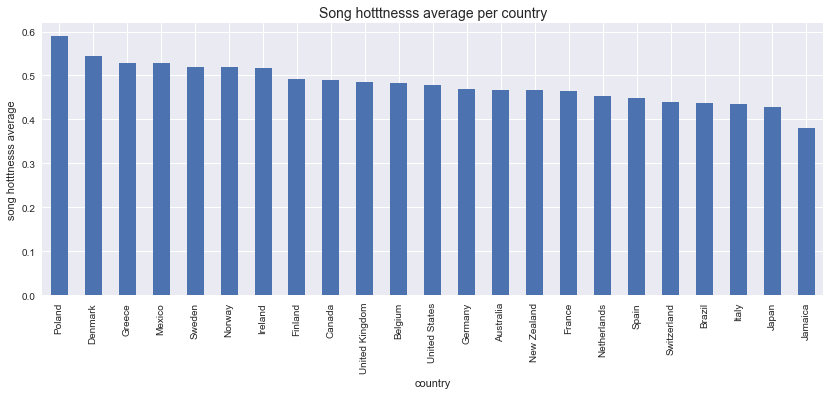

In [109]:
ax = (song_hotttnesss_avg_per_country['song hotttnesss']).\
                                                sort_values(ascending=False).\
                                                plot(kind='bar', figsize=(14,5))

ax.set_title('Song hotttnesss average per country', fontsize=14)
ax.set_xlabel('country')
ax.set_ylabel('song hotttnesss average')

ax.set_xticklabels(song_hotttnesss_avg_per_country.sort_values(by='song hotttnesss', ascending=False)['country']);

In [100]:
draw_map(song_hotttnesss_avg_per_country)

scale: [0.0, 0.31, 0.38, 0.44, 0.48999999999999999, 0.71999999999999997]


**Observations:**

Unfortunately, by introducing a minimum number of songs per country of, all songs from Africa tend to get lost, as well as most songs from Asia and from Latin America, with the exception of Japan and Brasil.

However, by varying the threshold between relatively low and high values, we also see that the ranking for the average `song hotttnesss` does not change that much either. 

* With a threshold of 240, the top-10 countries are, in decreasing order: Denmark, Mexico, Sweden, Norway, Ireland, Finland, Canada, United Kingdom, United States, Germany.
* With a threshold of 100, the top-10 countries are, in decreasing order: Poland, Denmark, Greece, Mexico, Sweden, Norway, Ireland, Finland, Canada and the United Kingdom.
* With a threshold of 60, the top-10 countries are, in decreasing order: Poland, Denmark, Puerto Rico, Greece, Mexico, Sweden, Norway, Ireland, Finland, Canada.

Sweden, Denmark or Norway threfore seem to be a good pick for the artist country of origin.
It is not that they necessariy have more "hot" songs in Scandinavia, but more that they seem to proportionally have less not-so-good ones, compared to the United States for instance.

Still, the relatively high `song hotttnesss` average for these countries, which is between 0.5 and 0.6, is hence not excessively high either. This could then also be reflecting the presence of a large proportion of "average" songs, and not the presence of particularly popular ones.

We will therefore slightly change our approach for determining the top artist countries of origin, by not looking at the global `song hotttnesss`, but rather at the proportion of popular songs over all songs associated to a given country.
It could indeed be the case that a country displays a very large proportion of songs rated very lowly, but an equally large proportion of popular songs. Its average `song hotttnesss` would then be similar to a the one of a country with only a few popular songs, a few not so popular ones, and many average ones.
The first country however produced more popular songs than the second one, despite the similar `song hotttnesss` averages. 

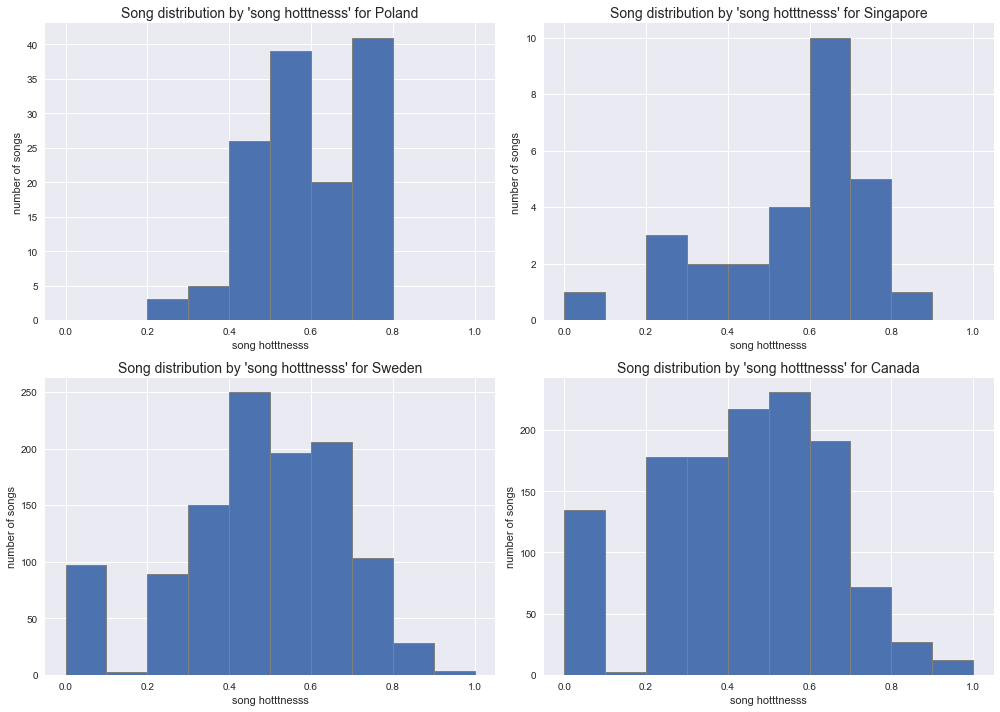

In [111]:
def plot_song_distribution_by_country(ax, country):
    df = data_geo[(data_geo['country'].isin([country]))]['song hotttnesss']

    bins = np.arange(0,1.1, 0.1)
    ax.hist(df.values, bins=bins, edgecolor='gray', linewidth=1.0)
    ax.set_title('Song distribution by \'song hotttnesss\' for ' + country, fontsize=14)
    ax.set_xlabel('song hotttnesss')
    ax.set_ylabel('number of songs')
    
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=False, figsize=(14,10))

plot_song_distribution_by_country(ax1, 'Poland')
plot_song_distribution_by_country(ax2, 'Singapore')
plot_song_distribution_by_country(ax3, 'Sweden')
plot_song_distribution_by_country(ax4, 'Canada')

f.tight_layout()

For instance, it turns out Poland has one of the highest `song hotttnesss` average, but essentially lacks the very popular songs, the ones with a `song hotttnesss` greater than 0.9 (and by the way also the not-at-all popular songs, with a `song hotttnesss` of 0.0).

Sweden or Canada on the other hand, like the majority of countries, have many average to not-so-popular songs. But then they are also among the countries which have the highest proportion of popular songs, as small as it may be.

Singapore too displays a high `song hotttnesss` average, as well as a high proportion of popular songs. What can be misleading however is that there are very few compiled songs for Singapore, 28 in total, and only a single song with a `song hotttnesss` above 0.8.

In the follwoing ranking, hence again only consider countries who have a "large enough" number of recorded songs.

In [112]:
threshold_country = 100

df = data_geo.groupby('country').size().to_frame('count').reset_index()
keep_countries = df[df['count'] >= threshold_country]['country'].tolist()

print('Number of countries selected:', len(keep_countries), 'out of', len(df))

threshold = 0.8

df = pd.DataFrame()
df['count'] = data_geo[(data_geo['song hotttnesss'] >= threshold) 
                      & data_geo['country'].isin(keep_countries)].groupby('country').size()
df = df.reset_index() 
df['total count'] = data_geo[data_geo['country'].isin(df['country'])].groupby('country').size().tolist()
df['ratio'] = df['count']/df['total count']

df.sort_values(by='ratio', ascending=False)

Number of countries selected: 23 out of 82


country  count  total count     ratio
1           Canada     39         1243  0.031376
12          Sweden     31         1124  0.027580
9           Mexico      5          240  0.020833
11          Norway      6          321  0.018692
5           Greece      2          109  0.018349
2          Denmark      5          285  0.017544
14   United States    349        20376  0.017128
13  United Kingdom     77         4831  0.015939
6          Ireland      4          268  0.014925
3           France      7          688  0.010174
10     New Zealand      1          103  0.009709
7            Italy      3          312  0.009615
0        Australia      6          725  0.008276
8          Jamaica      1          169  0.005917
4          Germany      3         1269  0.002364

**Observations:**

With a `song hotttnesss` threshold of 0.8, and when keeping countries having at least 20 recorded songs, Puerto Rico and Singapore score top for the highest proportion of popular songs.
We notice that these two countries have 3 respectively 1 song with a `song hotttnesss` above 0.8, which is in absolute not a lot though. 

By increasing the threshold for the minimum number of songs to 100, both countries are now discarded. 
The top-10 countries are then in order: Canada, Sweden, Mexico, Norway, Greece, Denmark, the United States, the United Kingdom, Ireland and France. 
These are to a large extent the same countries found previously, but in a slightly different order.

**Conclusion:**

We tried two slightly different approaches in order to determine the countries where popular songs are most likely to be found.
In the end, it turns out songs coming from Scandinavian countries in overall score high when it comes down to the `song hotttnesss`, and this in both rankings.
Individual countries like Canada, Mexico, Greece or other countries like Poland or Singapore also rank high, with slight variations depending on the chosen thresholds.

These rankings however are dealing with countries with a very unbalanced number of songs (a few 28 for Singapore, 1243 for Canada, and 20376 for the United States for instance), which also raises the question whether the compiled songs are in fact representative for the country.

### What to put in the lyrics (Influence of lyrics on the popularity of a song)
In this section, we provide an analysis of the lyrics of the songs, using the related musiXmatch dataset.

Official webpage of the musiXmatch dataset:
https://labrosa.ee.columbia.edu/millionsong/musixmatch
 
* Train set:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset_train.txt.zip

* Test set:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset_test.txt.zip

* 779k matches:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_779k_matches.txt.zip

* Full list of stemmed words:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/full_word_list.txt.zip
(498,134 unique words, total of 55,163,335 occurrences)

#### Loading the data

In [101]:
path_lyrics = './data/lyrics/'

In [102]:
# load the 'full_word_list.txt' file, containing all the words present in all the songs
# use <encoding='utf-8-sig'> because of the variety of characters
full_word_list = pd.read_csv(path_lyrics + 'full_word_list.txt', skiprows=7, sep='<SEP>', header=None, engine='python', encoding='utf-8-sig')
full_word_list.columns = ['word', 'count']

print('Number of words:', len(full_word_list))
full_word_list.head()

Number of words: 498134


word    count
0    i  2078808
1  the  1863782
2  you  1744257
3   to  1067578
4  and  1055748

We immediately see that the top words in the lyrics are in fact the english stopwords 'I', 'the', 'you', 'to', 'and', ..., which is not surprising, given that most of the songs come from the United States and the United Kingdom.

If we look at the last rows of the full list of words though, we see that some of the lyrics actually contain japanese "words":

In [103]:
full_word_list.tail(3)

word  count
498131    ｢ただのマイリー」と      1
498132  ｢どうしたんだ｣と聞いた      1
498133    ｢何を考えてる｣って      1

In fact, the Million Song Dataset seems to contain songs with lyrics written in many more languages than just English: by scrolling through the `full_word_list.txt` file, one can spot words which come from a variety of languages such as Spanish, German, Swedish, ...

Unfortunately, such songs are very sparse compared to the ones written in English - the word count actually indicates 1 for each japanese "word" in the list. This makes it difficult to use them in the lyrics analysis.
In any case though, they do not appear in the top-5000 words kept in the `mxm_dataset_train.txt` and the `mxm_dataset_test.txt` datasets.
This means they cannot be included in the analysis, since the bag-of-words lyrics only consider the top-5000 most frequent words.

We will now load the top-5000 most frequent words over all the lyrics.

In [104]:
# load the top-5000 words
top_words_list = []

# the top-5000 words can be found after the line starting with '%' in the 'mxm_dataset_train.txt' file
with open(path_lyrics+'mxm_dataset_train.txt', encoding='utf-8-sig') as f:
    for line in f:
        if line.startswith('%'):
            top_words_list = line[1:] # drop the '%' marking the beginning of the line
            break

top_words_list = top_words_list.split(',')
print('Number of words:', len(top_words_list))
top_words_list[0:10]

Number of words: 5000


['i', 'the', 'you', 'to', 'and', 'a', 'me', 'it', 'not', 'in']

As observed just previously, many of the top-5000 words seem to be stopwords. 
This cannot be helped though, since stopwords are indeed the most frequent words in practice.

By definition, stopwords are words that bear little meaning, in particular for search queries, and which are therefore often removed during the preprocessing step.
However, there are two reasons we will not remove the stopwords from our lyrics analysis:
* The first one is that we are not dealing with search queries.
* The second one is because songs are intrinsically based on repetitive patterns, even more than prose, so that some of these stopwords can actually be considered as an important part of the lyrics.

We now load the musiXmatch matches from the both the `mxm_dataset_train.txt` dataset and the `mxm_dataset_test.txt` dataset.
Since we are doing a prediction task per se, we simply merge both datasets into a single one.

In [105]:
def load_mxm_dataset(filename):
    
    entries = []
    with open(path_lyrics+filename) as f:
        # skip the first 18 lines
        lines = f.readlines()[18:] 
        for line in lines:
            line = line.split(',')

            entry = []
            entry.append(line[0])
            entry.append(line[1])

            words = {}
            line = line[2:]
            for item in line:            
                words[int(item.split(':')[0])] = int(item.split(':')[1])
            entry.append(words)

            entries.append(entry)
    
    return entries

In [106]:
# load the 'mxm_dataset_train.txt' file
filename = 'mxm_dataset_train.txt'
entries = load_mxm_dataset(filename)

# load the 'mxm_data_set_test.txt' file
filename = 'mxm_dataset_test.txt'
entries.extend(load_mxm_dataset(filename))

print('Number of songs:', len(entries))

Number of songs: 237662


The musiXmatch dataset provides a matching between 779056 songs of the Million Song Dataset, but in total, there are only 237 662 (train set: 210 519, test set: 27 143) songs whose lyrics are provided (as a bag-of-word).
This means that at most this number of songs can be used for the lyrics analysis.

In [107]:
mxm_dataset = pd.DataFrame(entries)
mxm_dataset.columns = ['track id', 'mxm track id', 'words']
mxm_dataset.head()

track id mxm track id  \
0  TRAAAAV128F421A322      4623710   
1  TRAAABD128F429CF47      6477168   
2  TRAAAED128E0783FAB      2516445   
3  TRAAAEF128F4273421      3759847   
4  TRAAAEW128F42930C0      3783760   

                                               words  
0  {1: 6, 2: 4, 3: 2, 4: 2, 5: 5, 6: 3, 7: 1, 8: ...  
1  {1: 10, 3: 17, 4: 8, 5: 2, 6: 2, 7: 1, 8: 3, 9...  
2  {1: 28, 2: 15, 3: 2, 4: 12, 5: 22, 6: 2, 7: 2,...  
3  {1: 5, 2: 4, 3: 3, 4: 2, 5: 1, 6: 11, 9: 4, 12...  
4  {1: 4, 4: 5, 5: 7, 6: 2, 7: 4, 9: 1, 10: 1, 11...

In [108]:
# load the 'mxm_779k_matches.txt' file
mxm_779k_matches = pd.read_csv(path_lyrics+'mxm_779k_matches.txt', skiprows=18, sep='<SEP>', header=None, engine='python')
mxm_779k_matches.columns = ['track id', 'artist name', 'title', 'mxm track id', 'mxm artist name', 'mxm title']

print('Number of songs matched:', len(mxm_779k_matches))
mxm_779k_matches.head()

Number of songs matched: 779056


track id       artist name  \
0  TRMMMKD128F425225D  Karkkiautomaatti   
1  TRMMMRX128F93187D9    Hudson Mohawke   
2  TRMMMCH128F425532C       Yerba Brava   
3  TRMMMXN128F42936A5  David Montgomery   
4  TRMMMBB12903CB7D21        Kris Kross   

                                               title  mxm track id  \
0                                        Tanssi vaan       4418550   
1                                  No One Could Ever       8898149   
2                                     Si Vos QuerÃ©s       9239868   
3  Symphony No. 1 G minor "Sinfonie Serieuse"/All...       5346741   
4                                  2 Da Beat Ch'yall       2511405   

    mxm artist name                                          mxm title  
0  Karkkiautomaatti                                        Tanssi vaan  
1    Hudson Mohawke                                  No One Could Ever  
2       Yerba Brava                                      Si vos queres  
3     Franz Berwald  Symphony No. 1 in G minor "Sinfonie SÃ©rieuse"...  
4        Kris Kross                                  2 Da Beat Ch'yall

We now merge the 779k matched songs with their correspondong `song hotttnesss` and `words` bag of words.

In [109]:
print('Number of songs in the dataset:', len(data))

data_lyrics = mxm_779k_matches.merge(data[['track id', 'song hotttnesss']])
print('Number of songs matched with the musiXmatch track id dataset:', len(data_lyrics ))

data_lyrics = data_lyrics .merge(mxm_dataset[['track id', 'words']])
print('Number of songs matched with the musiXmatch lyrics dataset:', len(data_lyrics ))

data_lyrics = data_lyrics.drop(['mxm track id', 'mxm artist name', 'mxm title'], axis=1)
data_lyrics.head(1)

Number of songs in the dataset: 159430
Number of songs matched with the musiXmatch track id dataset: 154663
Number of songs matched with the musiXmatch lyrics dataset: 60146


track id artist name   title  song hotttnesss  \
0  TRGMMCD128F4244A89  Luka Bloom  Soshin         0.405116   

                                               words  
0  {1: 5, 2: 14, 3: 2, 4: 6, 5: 3, 6: 3, 7: 1, 9:...

We see that out of the 159 430 songs in our dataset, 154 663 of them could be matched with the musiXmatch ID dataset. 
In the end, 60 146 songs could be matched between our dataset and the musiXmatch bag-of-words lyrics dataset.

(This is much better than when we used the Million Song Dataset subset, where only 2350 songs could be eventually matched with the musiXmatch lyrics dataset)

#### Analysis

We want to find out if there are certain words popular songs (i.e. with a high `song hotttnesss` value) tend to contain more frequently than songs with an average rating. 

In [125]:
def word_id_to_word(word_id_list):
    return [top_words_list[x-1] for x in word_id_list]

def word_to_word_id(word_list):
    return [top_words_list.index(x)+1 for x in word_list]

In [111]:
def create_top_words_ranking(threshold, sort_by, verbose=False):
    top_mxm_matches = data_lyrics[data_lyrics ['song hotttnesss'] >= threshold]

    # get all the words in the top songs, according to the threshold 
    words_dict_list = top_mxm_matches['words'].tolist()

    # count the number of words over these songs
    nb_words = len((flatmap([d.keys() for d in words_dict_list])))
    
    if(verbose):
        print('Song hotttnesss threshold:', threshold)
        print('Number of songs selected:', len(top_mxm_matches))
        print('Number of words:', nb_words)

    top_words = pd.DataFrame()
    top_words['word id'] = (list((flatmap([d.keys() for d in words_dict_list]))))

    # count the number of songs containing this word
    top_words = top_words.groupby(['word id']).size().to_frame('song count').reset_index()
    #top_words.rename(columns={0:'song count'}, inplace=True)
    
    # todo: too slow --> remove
    #top_words['total count'] = top_words['word id'].apply(lambda key: sum([d[key] for d in words_dict_list if key in d]))
   
    # count the total number of occurences by word
    word_occurences = defaultdict(int)
    for entry in words_dict_list:
        for key in entry:
            word_occurences[key] += entry[key]
           
    top_words['total count'] = top_words['word id'].map(word_occurences)
    
    # compute the frequency of each word
    top_words['frequency'] = top_words['total count'].apply(lambda count: count/(1.0*nb_words))
    
    # map each word id to the acual corresponding word
    top_words['word'] = top_words['word id'].apply(lambda row: top_words_list[row-1])
   
    # reorder the columns
    top_words = top_words.reindex_axis(['word id', 'word', 'song count', 'total count', 'frequency'], axis=1)
    
    # sort the words according to their frequency, in descending order
    top_words = top_words.sort_values(sort_by, ascending=False).reset_index(drop=True)
    
    #rank = []
    #previous_rank = 1
    #previous = top_words[sort_by][0]
    #for item in top_words[sort_by]:
    #    if(item == previous):
    #       rank.append(previous_rank)
    #    else:
    #        rank.append(previous_rank + 1)
    #        previous_rank += 1
    #        previous = item
    
    #top_words['rank'] = rank
    
    return top_words

In [112]:
threshold = 0.8
create_top_words_ranking(threshold, 'song count', True).head(10)

Song hotttnesss threshold: 0.8
Number of songs selected: 2060
Number of words: 174967


word id word  song count  total count  frequency
0        2  the        1897        19650   0.112307
1        4   to        1776        10923   0.062429
2        5  and        1772        12239   0.069950
3        1    i        1765        24329   0.139049
4        3  you        1738        20693   0.118268
5        6    a        1616         9382   0.053622
6        8   it        1589        10004   0.057176
7       12   is        1550         6359   0.036344
8       10   in        1549         6428   0.036738
9        9  not        1522         8908   0.050912

If we sort the words by the number of songs which contain at least one occurence of this word, then we see that the word 'the' is ranked first, just like in the english word frequency.

Here however, we only counted the number of songs containing a certain word, and did not take into account the actual number of occurences of this word.
Moreover, stopwords are very likely to be consistently present in almost every songs. 
With an increasing `song hotttnesss` threshold, the number of selected songs decreases, and so does the number of distinct words. 
Hence, chances that the very common stopwords 'the', 'you', 'I', ... are placed in the top positions may be in the end only due to the fact that the lexical field decreases in size.
Ranking the words by song count provides some information, but may then not be the best approach.

We therefore try to rank the words by frequency over all selected songs, that is, by taking the total number of occurences of the word and dividing it by the total number of words.
The idea is that the frequency of some stopwords such as 'the', 'to', ... will not vary much with the `song hotttnesss`, while other may actually do so.

In [47]:
threshold = 0.6
create_top_words_ranking(threshold, 'frequency', True).head(20)

Song hotttnesss threshold: 0.6
Number of songs selected: 20211
Number of words: 1683352


word id  word  song count  total count  frequency
0         1     i       16297       206382   0.122602
1         2   the       17880       183043   0.108737
2         3   you       15870       170794   0.101461
3         4    to       16860       103223   0.061320
4         5   and       16558       103177   0.061293
5         6     a       15774        84448   0.050167
6         8    it       14381        83277   0.049471
7         9   not       13749        72461   0.043046
8         7    me       13215        69515   0.041296
9        10    in       14821        59425   0.035302
10       11    my       12249        58009   0.034460
11       12    is       14490        57523   0.034172
12       13    of       13568        52961   0.031462
13       14  your       11268        46831   0.027820
14       15  that       12174        45277   0.026897
15       16    do       10516        44650   0.026524
16       19    we        8646        42248   0.025098
17       20    am        9576        41681   0.024761
18       18   are       10842        39533   0.023485
19       17    on       11343        39141   0.023252

Unsurprisingly, just like before, the same stopwords 'I', 'you', 'the', 'to', ... are ranked at the top positions. 
But with this approach, the word 'the' is not ranked first anymore.

What is interesting as well is that the word 'you', which is ranked 18th in the English prose, has a much higher frequency in the popular songs.
Inversely, the word 'the', which is ranked first in the english word frequency, is here ranked slightly lower in terms of frequency.

The first top-30 words in English prose are displayed in the following table, from the results of the analysis based on the Oxford English Corpus:

|rank | word ||rank | word ||rank | word ||rank | word ||rank | word ||rank | word |
|-----|:-----||-----|:-----||-----|:-----||-----|:-----||-----|:-----||-----|:-----|
| 1   | the  || 6   | a    || 11  | it   || 16  | he   || 21  | this || 26  | they |
| 2   | be   || 7   | in   || 12  | for  || 17  | as   || 22  | but  || 27  | we   |
| 3   | to   || 8   | that || 13  | not  || 18  | you  || 23  | his  || 28  | say  |
| 4   | of   || 9   | have || 14  | on   || 19  | do   || 24  | by   || 29  | her  |
| 5   | and  || 10  | I    || 15  | with || 20  | at   || 25  | from || 30  | she  |

We also see that just like in English prose, the word 'I' (10th rank) is systematically placed before the word 'you' (18th rank).
What is more, we notice that the rank of the word 'we' is higher in the songs than in the English word frequency.
Otherwise, all other words ranking top in the English word frequency tend to rank lower in general in the lyrics frequency.

---
The result of the most common English words analysis based on the Oxford English Corpus can be found at https://en.wikipedia.org/wiki/Most_common_words_in_English (as a list).
Another ranking is also available at https://www.wordandphrase.info/frequencyList.asp (by querying a word individually).

To explore our findings further, we will look at how these frequencies evolve when the `song hotttnesss` threshold increases.

In [113]:
def get_word_frequency(word, ranking):
    if len(top_words_ranking) > 0:
        if(len(ranking[ranking['word'] == word]['frequency'].values) == 0):
            return float('NaN')
        else:
            return ranking[ranking['word'] == word]['frequency'].values[0]
    else:
        return float('NaN')

In [143]:
# define the thresholds for the 'song hotttnesss'
step = 0.02
thresholds = np.arange(0.0, 1.0 + step, step)

In [144]:
# the list of word we want to to investigate
words_list = ['you', 'i', 'we', 'the', 'and', 'is', 'to', 'my', 'your', 'it', 'they', 'he', 'she']
word_ranks_dict = {}

# initialize the dictionary
for word in words_list:
    word_ranks_dict[word] = []

# for each threshold value, create the ranking and store the ranking for each selected word
for threshold in thresholds:
    top_words_ranking = create_top_words_ranking(threshold, 'frequency', False)
    for word in words_list:
        frequency = get_word_frequency(word, top_words_ranking)
        word_ranks_dict[word].append(frequency)

In [138]:
# run this cell of code in order to add a single word in the dictionary
word = 'love'
word_ranks_dict[word] = []

for threshold in thresholds:
    top_words_ranking = create_top_words_ranking(threshold, 'frequency', False)
    frequency = get_word_frequency(word, top_words_ranking)
    word_ranks_dict[word].append(frequency)

In [145]:
# a list of colours to use, if many lines to plot
colors = ['#a6cee3', '#1f78b4', '#2e86c1', '#b2df8a', '#33a02c', '#e31a1c',
          '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']

# default colours
# colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

# a list of markers to use, if the plot gets printed in black & white
markers = ['o', 's', 'v', '^', 'd', 'p', 'h', 'X']

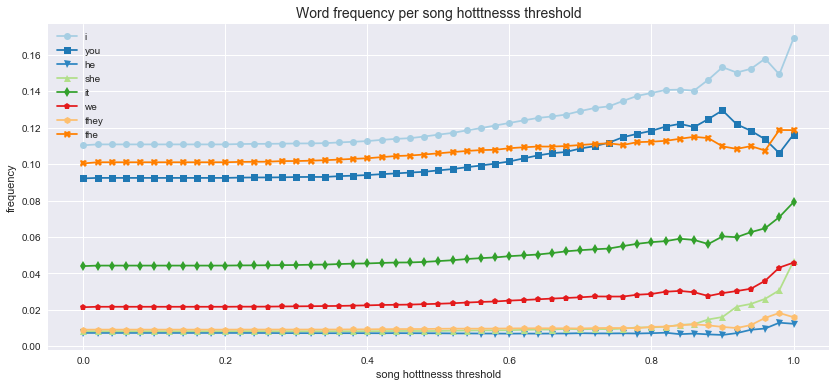

In [146]:
figure()
plt.figure(figsize=(14,6))

words_list = ['i', 'you', 'he', 'she', 'it', 'we', 'they', 'the']

i = 0
for word in words_list:
    plt.plot(thresholds, word_ranks_dict[word], linestyle='-', marker=markers[i], color=colors[i])
    i += 1
    
plt.title('Word frequency per song hotttnesss threshold', fontsize=14)
plt.xlabel('song hotttnesss threshold')
plt.ylabel('frequency')
plt.legend(labels=words_list)

plt.savefig('./report/images/stopwords_frequency_vs_song_hotttnesss.png', dpi=100)

Unsurprisingly, the number of selected songs decreases when the `song hotttnesss` threshold increases.
Only 45 songs have a `song hotttnesss` greater or equal than 0.98, and there is only a single song with the highest `song hotttnesss`.
Therefore, it may be difficult to formulate an interpretation out of the frequencies for the last couple of threshold values.

We immediately notice the sharp drop at 0.90 for the word 'you', whose frequency had been steadily growing up to this point.

One explanation is that there might not be enough data for songs with a `song hotttnesss` > 0.90, hence the skewed results (284 songs selected). The frequency of the word 'the' indeed seems unstable past a threshold of 0.90, although we supposed it would be one of the word for which the frequency remains rather unchanged.

However, the results might also be genuine, which would then turn out to be very interesting.

#### Removing English stopwords
We gained some insights into the lyrics of the songs in the MSD by not removing the stopwords from the lyrics.
Now, in this second part, we will remove them (at least most of them), and see which are the resulting top words in the lyrics.

To this end, we compiled a list of English stopwords into a single file, by using various freely-available lists of stopwords:
* https://www.ranks.nl/stopwords
* http://www.lextek.com/manuals/onix/stopwords1.html

* (https://algs4.cs.princeton.edu/35applications/stopwords.txt) 
*(note: maybe "too many" stopwords in this one)*

We first collected all the words into a single list, removed the duplicates, sorted the remaining words in alphabetical order, and finally wrote the result to a new file.

In [116]:
filename = 'stopwords.txt'
with open(path_lyrics+filename, 'r') as f:
    #next(f) # skip the first line (header - the source of the file)
    stopwords = f.read().splitlines()

stopwords = list(filter(None, stopwords))
print('Number of stopwords:', len(stopwords))

Number of stopwords: 488


*Code for adding more stopwords: insert the name of the file containing the stopwords, the new ones will be appended to the existing `stopwords.txt` file*

In [381]:
# read the file of potentially new stopwords
filename = 'stopwords_new.txt'
with open(path_lyrics+filename, 'r') as f:
    stopwords_new = f.read().splitlines()

print('Number of stopwords in new file:', len(stopwords_new))

# read the file of already compiled stopwords
filename = 'stopwords.txt'
with open(path_lyrics+filename, 'r') as f:
    stopwords = f.read().splitlines()

print('Number of stopwords already collected:', len(stopwords))

stopwords.extend(stopwords_new)
stopwords = list(set(stopwords))
stopwords.sort()

print('New number of stopwords:', len(stopwords))

# write all the stopwords to file again
filename = 'stopwords.txt'
f = open(path_lyrics+filename, 'w')
for item in stopwords:
    f.write("%s\n" % item)

Number of stopwords in new file: 0
Number of stopwords already collected: 488
New number of stopwords: 488


We now simply drop the rows of the top words ranking dataframe whose `word` is among the stopwords.
This gives a completely new ranking, devoid of most of the (English) stopwords.

*Implementation note: when working without the stopwords, one way would be to remove them from the list of words for each song before computing the ranking. 
Instead, what we do is compute the whole ranking, and only then drop the stopwords. 
Although this can be seen as inefficient, cleaning the previous dataframe beforehand is tedious too, as it involves iterating over all songs and recomputing a new bag-of-words for each of them.*

In [119]:
threshold = 0.8
df = create_top_words_ranking(threshold, 'frequency', True)
df[~df['word'].isin(stopwords)].head(10)

Song hotttnesss threshold: 0.8
Number of songs selected: 2060
Number of words: 174967


word id   word  song count  total count  frequency
29       27   love         710         2861   0.016352
33       46     oh         557         2610   0.014917
47       39   time         732         1836   0.010493
56       61   feel         599         1686   0.009636
59       70     ca         563         1526   0.008722
61       76   yeah         409         1491   0.008522
68       95   caus         480         1236   0.007064
70       73   babi         300         1219   0.006967
72       71    day         480         1166   0.006664
76       96  gonna         320         1102   0.006298

In [118]:
threshold = 0.3
df = create_top_words_ranking(threshold, 'frequency', True)
df[~df['word'].isin(stopwords)].head(10)

Song hotttnesss threshold: 0.3
Number of songs selected: 52767
Number of words: 4257177


word id  word  song count  total count  frequency
28       27  love       15632        60527   0.014218
40       39  time       17177        41533   0.009756
46       46    oh       10582        38648   0.009078
57       61  feel       13113        31243   0.007339
63       70    ca       11813        28607   0.006720
66       47    la        4028        27866   0.006546
69       38   que        3458        25981   0.006103
71       76  yeah        7374        25042   0.005882
72       42    de        4132        24508   0.005757
73       73  babi        6584        24387   0.005728

**Observations:**

* With a `song hotttnesss` threshold of 0.8, some of the top ranked words are now 'love', 'time' and 'feel' - we notive that 'love' is actually far ahead of the other words, with a total count of 2 861, whereas 'time' and 'feel' follow with 1 836 respectively 1 686 occurrences
* Interestingly, 'oh' and 'yeah', which are not even "proper" words, but more informal contractions or interjections, appear at the second respectively fifth position *(see? no need for intellectual lyrics)* 
* For some words such as 'ca', it is unclear to which (stemmed?) word they correspond to though

In [120]:
# the list of word we want to investigate
words_list = ['love', 'time', 'feel', 'oh', 'yeah', 'gonna', 'watcha', 'life', 'night', 'eye', 'heart', 'world']
word_ranks_dict = {}

# initialize the dictionary
for word in words_list:
    word_ranks_dict[word] = []

# for each threshold value, create the ranking and store the ranking for each selected word
for threshold in thresholds:
    top_words_ranking = create_top_words_ranking(threshold, 'frequency', False)
    for word in words_list:
        frequency = get_word_frequency(word, top_words_ranking)
        word_ranks_dict[word].append(frequency)

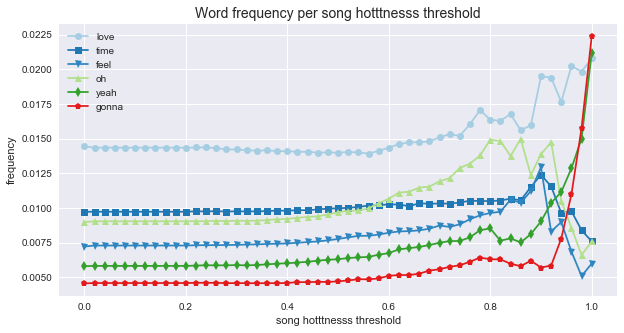

In [121]:
figure()
plt.figure(figsize=(10,5))

words_list = ['love', 'time', 'feel', 'oh', 'yeah', 'gonna']

i = 0
for word in words_list:
    plt.plot(thresholds, word_ranks_dict[word], linestyle='-', marker=markers[i], color=colors[i])
    i += 1
    
plt.title('Word frequency per song hotttnesss threshold', fontsize=14)
plt.xlabel('song hotttnesss threshold')
plt.ylabel('frequency')
plt.legend(labels=words_list)



**Observations:**
* Also without the stopwords, we observe similar drops for certain word frequencies when the `song hotttnesss` threshold goes above 0.9
* There is a crazy increase in 'yeah' frequency when the `song hotttnesss` threshold goes above 0.8. Inversely, drop in the 'oh' frequency. Since these are interjections, lyrics may or may not include them (in particular 'oh'), maybe explaining the unstable results.
* For the top songs, with a `song hotttnesss` threshold above 1.0, the top words are 'yeah', 'gonna' and 'love'

In [443]:
data_lyrics.head(1)

track id artist name   title  song hotttnesss  \
0  TRGMMCD128F4244A89  Luka Bloom  Soshin         0.405116   

                                               words  
0  {1: 5, 2: 14, 3: 2, 4: 6, 5: 3, 6: 3, 7: 1, 9:...

In [127]:
words = ['yeah', 'oh']
word_id_list = word_to_word_id(words)
print('Number of songs containing', words, ':', len(data_lyrics[data_lyrics['words'].apply(lambda dic: all(word_id in dic.keys() for word_id in word_id_list))]))

Number of songs containing ['yeah', 'oh'] : 3631


In [ ]:
# complete analysis a bit here

#### Only English lyrics for the top songs?

Since the MSD contains an overhelming majority of songs from the United States and the United Kingdom, we suspect that most popular songs (and most songs in general), are written in English.

This is not what the geographical analysis we performed before hand suggested: the countries with the highest `song hotttnesss` average tended to be Scandinavian countries and, depending on the minimum number of songs required to take part in the ranking, Poland, Greece, Mexico, ...
English-speaking countries such as the United Kingdom, the United States, Canada or Australia were ranked fairly well, but not at the top nonetheless.

We hence want to look more closely at the country of origin and the language of the lyrics for the songs with the highest `song hotttnesss` values.
To this end, we merge the dataframes we used for the geographical analysis with the dataframe we used for the lyrics analysis.

In [719]:
df = pd.merge(data_lyrics, data_geo, on='track id', how='left')
df = df.drop(['song hotttnesss_x'], axis=1)
df.rename(columns={'song hotttnesss_y':'song hotttnesss'}, inplace=True)
print('Number of songs matched:', len(df))
df.head(1)

Number of songs matched: 60146


track id artist name   title  \
0  TRGMMCD128F4244A89  Luka Bloom  Soshin   

                                               words  song hotttnesss  \
0  {1: 5, 2: 14, 3: 2, 4: 6, 5: 3, 6: 3, 7: 1, 9:...         0.405116   

   latitude  longitude  country  city  
0  53.50807   -8.42945  Ireland  None

In [722]:
threshold = 1.0
df[df['song hotttnesss'] >= threshold ].groupby('country').size().to_frame('count').reset_index()

country  count
0  United Kingdom      1
1   United States      5

With a `song hotttnesss` threshold of 1.0 (the highest possible value for the `song hotttnesss`), we indeed see that the country of origin of the selected songs are exclusively the United States and the United Kingdom - two English-speaking countries.

In [782]:
threshold = 0.8
df[df['song hotttnesss'] >= threshold ].groupby('country').size().to_frame('count').reset_index()

country  count
0        Australia      5
1           Canada     20
2         Colombia      1
3          Denmark      3
4           France      3
5          Germany      1
6           Greece      1
7          Ireland      3
8           Mexico      1
9      New Zealand      1
10          Norway      6
11     Puerto Rico      1
12       Singapore      1
13          Sweden     13
14  United Kingdom     42
15   United States    220

When we lower the threshold, a few other countries get included in the selection.
In particular, we now have countries whose national language is not English.

The next step is to verify in which language the lyrics of the songs for these countries were written in.
We only display the first 10 words and the last 5 words (some songs may be using more than one language), in order to limit the output.

In [783]:
# define the English-speaking countries, for which we expect the lyrics to be written in English
countries_english = ['United Kingdom', 'United States', 'Canada', 'Australia', 'Ireland', 'New Zealand']

# select the countries not defined as English-speaking countries
countries = df[df['song hotttnesss'] >= threshold ].groupby('country').size().to_frame('count').reset_index()['country'].tolist()
countries = list(set(countries) - set(countries_english))

# display the <top> first and <top> last words
top = 5

for country in countries:
    print(country)
    for i in range(0, len(df[(df['song hotttnesss'] >= threshold) & (df['country'] == country)])):
        tmp = list(df[(df['song hotttnesss'] >= threshold) & (df['country'] == country)]['words'].values[i].keys())
        print(word_id_to_word(tmp[0:top]), '...', word_id_to_word(tmp[-top:]))
    print()

Sweden
['i', 'the', 'you', 'me', 'it'] ... ['anyon', 'hello', 're', 'ran', 'island']
['in', 'tu', 'o', 'et', 'est'] ... ['luna', 'hora', 'vita', 'ut', 'statu']
['i', 'the', 'you', 'a', 'me'] ... ['spring', 'spot', 'heartbeat', 'shallow', 'idl']
['i', 'the', 'you', 'to', 'and'] ... ['fix', 'total', 'prepar', 'journey', 'idl']
['i', 'the', 'to', 'and', 'me'] ... ['guilt', 'compromis', 'overcom', 'defi', 'confront']
['i', 'the', 'you', 'to', 'and'] ... ['glass', 'smell', 'nois', 'paid', 'strain']
['i', 'the', 'to', 'it', 'in'] ... ['void', 'burden', 'valu', 'wealth', 'forg']
['i', 'the', 'you', 'to', 'and'] ... ['sold', 'present', 'stain', 'journey', 'possibl']
['i', 'the', 'you', 'to', 'and'] ... ['bull', 'fountain', 'spanish', 'knive', 'pole']
['i', 'the', 'you', 'and', 'a'] ... ['posit', 'mask', 'film', 'rewind', 'increas']
['i', 'the', 'you', 'to', 'and'] ... ['paid', 'reveal', 'undon', 'split', 'leader']
['i', 'the', 'you', 'to', 'and'] ... ['rumor', 'singer', 'chord', 'poni', 'chamb

**Observations:**

For a `song hotttnesss` threshold of 0.8, we see that the top songs of each of these countries - with the exception of Colombia, Puerto Rico and Mexico - actually have their lyrics written in English.

The top songs for Colombia, Puerto Rico and Mexico are written in Spanish, but they represent a minority here. 

Sweden, which displays a quite large number of popular songs, compared to the other non Anglo-Saxon countries, does not seem to use Swedish as its preferred language for writting lyrics.
Surprisingly though, there seems to be one song from Sweden written in Spanish as well.

**Conclusion:**

It is clear now that the vast majority of the top songs are written in English, regardless of the country of origin of the artist.

What remains unclear though is whether the songs written in the native language of the country are ranked lower becase they do not reach a wide enough audience because of the language, or because there are simply are too few of them in the dataset, making them non-representative in this analysis.

So, English should definitely be the preferred language when writting the lyrics for a song.


#### A look at the not-so-popular songs
In this section, we want to find out whether there are words that are only present in popular songs or in not-so-popular songs.

To do this, we collect two sets of words (always among the top-5000 most frequent ones): the ones for the songs with a `song hotttnesss` above a certain threshold (popular songs) and the ones for songs with a `song hotttnesss` under a certain threshold (not-so-popular songs).

We then take the difference between the set of words of popular songs and the set of words of not-so-popular songs for finding words present only in popular songs, and vice-versa for finding words present only in not-so-popular songs.

In [ ]:
#intersection popular songs / not-so-popular songs
tmp = mxm_matches.copy()
head_threshold = 0.5
tail_threshold = 0.2
head = tmp[tmp['song hotttnesss'] > head_threshold]
tail = tmp[(tmp['song hotttnesss'] < tail_threshold) & (tmp['song hotttnesss'] > 0.0)]
tail = tmp[(tmp['song hotttnesss'] < tail_threshold)]

tail_words = set(flatmap([d.keys() for d in tail['words']]))
head_words = set(flatmap([d.keys() for d in head['words']]))

print('Number of songs with a song hotttnesss >', head_threshold, ':', len(head))
print('Number of songs with a song hotttnesss <', tail_threshold, ':', len(tail))
print('Number of words in common:', len(head_words.intersection(tail_words)))
print('Number of words only in songs with a song hotttnesss > ', head_threshold, ':', len(head_words.difference(tail_words)))
print('Number of words only in songs with a song hotttnesss < ', tail_threshold, ':', len(tail_words.difference(head_words)))

In [ ]:
print(list(map(lambda x: top_words_list[x-1], head_words.difference(tail_words))))
print(list(map(lambda x: top_words_list[x-1], tail_words.difference(head_words))))

**Observations:**

* In general, there are much more words in not-so-popular songs not in popular songs than the reverse
* We observe than the not-so-popular songs have their lyrics actually not written in English

**Conclusion:**

* Chances that a song becomes popular seem to be higher when the lyrics are written in English, and lower otherwise
* This could alos suggest a bias in the Echo Nest rating, where users tend to rate mostly English-written songs

*Some manual inspection*

Here, one can analyse the distribution of a particular word.
The frequency of a word is plotted for each individual song containg this word.

In [503]:
mxm_matches.head(1)

track id artist name   title  song hotttnesss  \
0  TRGMMCD128F4244A89  Luka Bloom  Soshin         0.405116   

                                               words  
0  {1: 5, 2: 14, 3: 2, 4: 6, 5: 3, 6: 3, 7: 1, 9:...

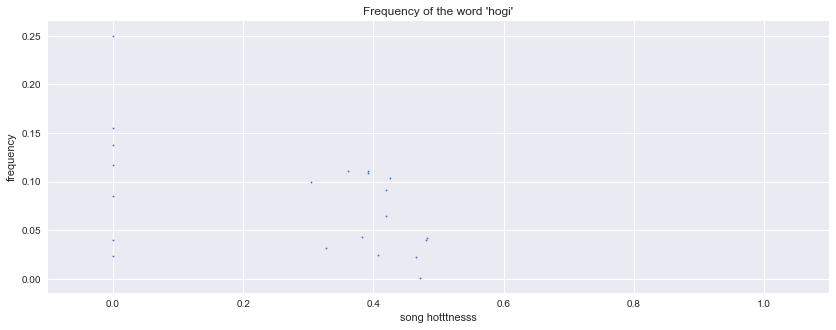

In [601]:
# się, jest
word = 'hogi'
word_id = top_words_list.index(word) + 1 # word indices start at 1 in the musiXmatch dataset

df = mxm_matches.copy()
df['count'] = mxm_matches['words'].apply(lambda word_dict: word_dict[word_id] if word_id in word_dict else 0)
df = df[df['count'] != 0]
df['length'] = mxm_matches['words'].apply(lambda word_dict: sum([word_dict[key] for key in word_dict]))
df['frequency'] = df['count'] / df['length'] 


ax = df.plot.scatter(x='song hotttnesss', y='frequency', s=2, figsize=(14,5))
ax.set_title('Frequency of the word \'' + word + '\'')
ax.set_xlim((-0.1, 1.1));

In [598]:
df.head()

track id artist name               title  song hotttnesss  \
389   TRGGWLN128F4256EBF    Zanzibar     Fejjel a falnak         0.000000   
405   TRGGCZL128F930E994   Celly Cel  Can't Tell Me Shit         0.471971   
694   TRGHLRF12903CC1AE5   PokolgÃ©p            Ezerszer         0.000000   
7045  TRHARHU12903CB3D01  Tankcsapda            KeverÃ©k         0.392009   
9466  TRHXTNQ128F932DFE5  Tankcsapda    A legjobb mÃ©reg         0.466305   

                                                  words  count  length  \
389   {6: 6, 12: 1, 42: 4, 359: 1, 421: 1, 476: 1, 6...      1      25   
405   {1: 15, 2: 40, 3: 23, 4: 16, 5: 24, 6: 48, 7: ...      1     997   
694   {6: 10, 42: 1, 104: 2, 642: 2, 1426: 1, 1480: ...      4      29   
7045  {6: 15, 42: 3, 104: 1, 112: 1, 421: 1, 428: 1,...      5      45   
9466  {5: 1, 6: 29, 12: 2, 42: 5, 104: 1, 112: 1, 12...      2      88   

      frequency  
389    0.040000  
405    0.001003  
694    0.137931  
7045   0.111111  
9466   0.022727

In [589]:
source = ColumnDataSource(data=dict(
    x=df['song hotttnesss'],
    y=df['frequency'],
    title=df['title'],
    artist=df['artist name'],
    song_hotttnesss=df['song hotttnesss'],
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),

])

hover_scatter_plot(source, hover, 
                   'Frequency of the word \'' + word + '\'', 'song hotttnesss', 'frequency',
                    None, None, 'horizontal', 'MSD', 800, 400)

In [ ]:
# - much more words in crappy songs not in popular songs than the reverse
# - some "crappy" songs are actually not written in English (Spanish, ...)
# - still not clear whether song hotttnesss of 0.0 means crappy
# - could still indicate a huge biais when song hotttnesss was rated (i.e. users rated mostly English songs)
#   in fact, all (almost?) "popular songs" are in English

# rule n°1: don't put 'hogi' in your song (hogi --> hogy/hoghya --> Hungarian)
# rule n°1 refined: just don't write your lyrics in Hungarian
# rule n°2: consider putting 'się' and 'jest', maybe also 'hypocrite' and 'structure'

<div class="lev2"><a href="#Table-of-Contents">Back to Top</a></div>
### Choosing a song duration

In [1684]:
describe(data, 'duration', True)

duration
count  159430.000000
mean      245.452216
std       111.820937
min         0.678730
25%       185.135870
50%       230.686890
75%       284.185670
max      3007.738320

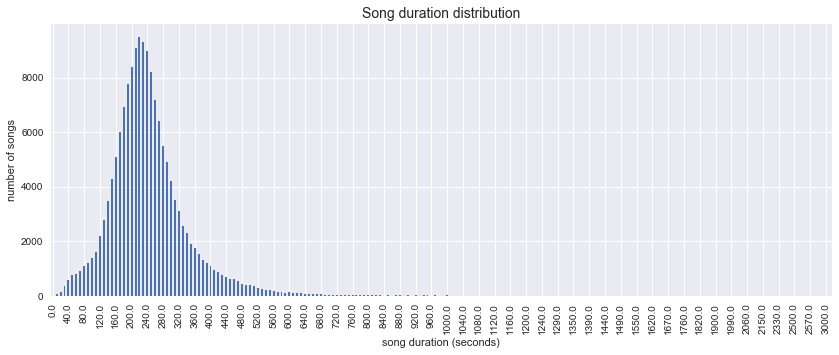

In [14]:
ax = round(data['duration'], -1).value_counts()\
                                .sort_index()\
                                .plot(kind='bar', 
                                      grid=True,
                                      figsize=(14, 5));
        
ax.set_title('Song duration distribution', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('number of songs')
set_ticks_with_step(ax, 4)

When using more songs, we the song duration distribution becomes squeezed to the left, because of the apparition of outliers: the maximal duration is 3007 seconds (50min 7s) whereas previously, it was only 1819 seconds (30min 19s).

The mean song average is relatively stable though, with a mean song duration of 245s for the subset, and 238s for the dataset.

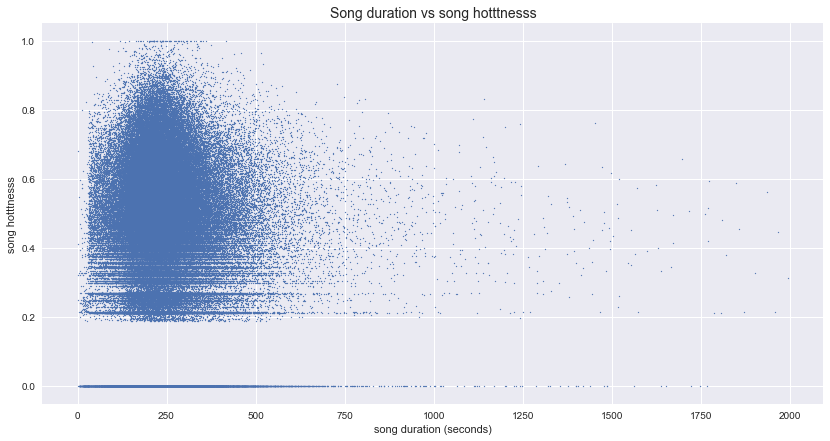

In [27]:
ax = data[data['duration'] < 2000].plot.scatter(x='duration', y='song hotttnesss', s=1, figsize=(14,7), grid=True, logx=False)

ax.set_title('Song duration vs song hotttnesss', fontsize=14)
ax.set_ylabel('song hotttnesss')
ax.set_xlabel('song duration (seconds)');

plt.savefig('./report/images/song_duration_vs_song_hotttnesss.png', dpi=100)

A trend which was not so visible with the subset is the decreasing `song hotttnesss` with the increasing song duration.
This can be better visualized when the x-axis is not in log-scale, but due to some outliers with a suprisingly long duration, we chose to display the plot with a log-scale for the x-axis.
Inversely, one additional advantage is that it allows us to get a better look at the songs with a very short duration (which are completely squeezed to the left of the plot otherwise). 

Moreover, it becomes clear there is a song duration intervall during which all songs with `song hotttnesss` of 1.0, or close to 1.0 can be found.
Of course, there is also a great deal of songs in this interval which do not have a high `song hotttnesss` value; in fact, 88.2% of the song durations fall within this intervall, with a `song hotttnesss` ranging from 0.0 to 1.0.

It is still unclear though whether a `song hotttnesss` of 0.0 effectively corresponds to a 0.0, or was just not evaluated. In the documentation, `NaN` values correspond to a non-evaluated `song hotttnesss`, but due to the apparent gap between 0.0 and 0.2, this assumption becomes questionable.

In [183]:
threshold = 1.0
print('Number of songs with a song hotttnesss >=', threshold, ':', len(data[data['song hotttnesss'] >= threshold]))

threshold_low = min(data[data['song hotttnesss'] >= threshold]['duration'])
threshold_high = max(data[data['song hotttnesss'] >= threshold]['duration'])
print('Proportion of songs with a duration between', threshold_low, 's and', threshold_high, 's:', round(len(data[(data['duration'] >= threshold_low) & (data['duration'] <= threshold_high)]) / len(data) * 100, 2), '%')

describe(data[data['song hotttnesss'] >= threshold], 'duration', True)

Number of songs with a song hotttnesss >= 1.0 : 63
Proportion of songs with a duration between 120.63302 s and 418.14159 s: 88.2 %


duration
count   63.000000
mean   251.190943
std     55.567511
min    120.633020
25%    214.752200
50%    239.046080
75%    285.361180
max    418.141590

The previous plot strongly suggests the duration of popular songs tends to fall within a certain interval. To verify this hypothesis, we plot the minimum, maximum and average duration of the songs for increasing `song hotttnesss` threshold.

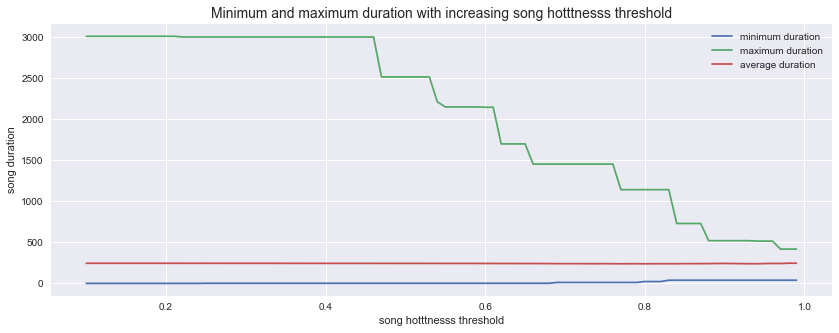

In [634]:
thresholds = np.arange(0.1, 1.0, 0.01)
min_durations = []
max_durations = []
avg_durations = []
for threshold in thresholds:
    min_durations.append(min(data[data['song hotttnesss'] >= threshold]['duration']))
    max_durations.append(max(data[data['song hotttnesss'] >= threshold]['duration']))
    avg_durations.append((data[data['song hotttnesss'] >= threshold]['duration']).mean())

figure()
plt.figure(figsize=(14,5))

plt.plot(thresholds, min_durations)
plt.plot(thresholds, max_durations)
plt.plot(thresholds, avg_durations)
plt.title('Minimum and maximum duration with increasing song hotttnesss threshold', fontsize=14)
plt.xlabel('song hotttnesss threshold')
plt.ylabel('song duration')
plt.legend(labels=['minimum duration', 'maximum duration', 'average duration']);

**Observations:**
* Indeed, the maximum song duration rapidly decreases when the `song hotttnesss` threshold increases, so that it eventually determines a rather tight interval for the most popular songs durations

**Conclusion:** 
* if you want your song to be "hot", don't make it longer than 419 seconds (6min 59s) (which is actually pretty long already, if one thinks about it...)
* on average though, 251 seconds (4min 11s) should maximize the chances it is rated "hot".

#### Lyrics length (estimated)

Typically, the longer the songs, the more lyrics this song contains (this may not apply for songs which are more intrsumental oriented).
Therefore, we also verify whether there is no siginficant difference when comparing the song duration with the `song hotttnesss`, and the lyrics length with the `song hotttnesss`. 

Since only the occurences of the top-5000 words are available, this will only be an estimation of the actual lyrics length though.
The estimated lyrics length for a given song is computed by summing all the word occurences for this song.

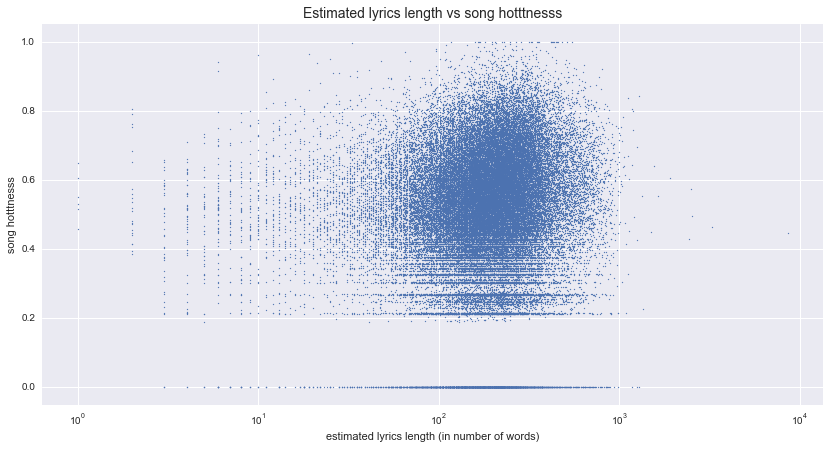

In [631]:
df = mxm_matches.copy()
df['length'] = df['words'].apply(lambda word_dict: sum([word_dict[key] for key in word_dict]))

ax = df.plot.scatter(y='song hotttnesss', x='length', s=1, figsize=(14,7), logx=True)
ax.set_title('Estimated lyrics length vs song hotttnesss', fontsize=14)
ax.set_ylabel('song hotttnesss')
ax.set_xlabel('estimated lyrics length (in number of words)');

The overall shape of the plot is rather similar to the one which displayed the song duration versus the `song hotttnesss`.
It is somehow less symetric though, with more songs having few lyrics than songs having many lyrics.

The popular songs still tend to fall within a tight interval for the lyrics lengths.

**Over the years**

Until now, all songs with a given `song hotttnesss` have been treated as a whole.
One additional aspect about the song duration we want to analyse though, is how this feature could affect the popularity of a song over the years.

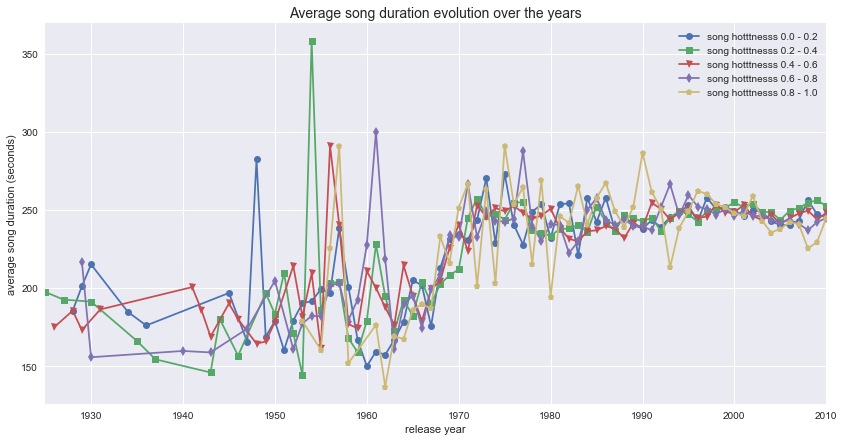

In [135]:
step = 0.2
thresholds = np.arange(0.0, 1.0, step)
markers = ['o', 's', 'v', 'd', 'p'] # if plot gets printed in black & white

i = 0
for threshold in thresholds:
    ax = data[(data['song hotttnesss'] >= threshold) 
              & (data['song hotttnesss'] < threshold + step if threshold < 0.8 else data['song hotttnesss'] <= threshold + step) 
              & (data['year'] < 2011)].groupby('year')['duration'].mean().\
                plot(figsize=(14,7), marker=markers[i], linestyle='-')
    i += 1
# we exclude songs with the 'year' 2011, because there are too few of them 
# (and then the plot is not so pretty either)

ax.set_title('Average song duration evolution over the years', fontsize=14)
ax.set_xlabel('release year')
ax.set_ylabel('average song duration (seconds)')
ax.legend(labels=['song hotttnesss ' + str(t) + ' - ' + str(t+step) for t in thresholds]);

plt.savefig('./report/images/song_duration_average_over_years.png', dpi=100)

**Observations:**
* The MSD acutally contains only few songs released before 1960, which makes it difficult to evaluate the impact of the song duration during this period
* Still, there are great variations for the average duration of the hotttessst songs between ~1970 and ~1995
* These variations seem to stabilize after 1995: all songs, regardless of their `song hotttnesss`, seem to converge to the same average duration
* What is more, after 2003 "hot" songs tend to be slightly shorter than the average song

**Conclusion:**

This suggests that either:
* the number of "hot" songs significantly increased, thus homogenizing the average song duration for "hot" songs
* songs with a relatively large duration tend to not be known by a wide public, making them less likely to be rated "hot"
* to be "hot", a song has to comply more and more to some standard song duration
  

<div class="lev2"><a href="#Table-of-Contents">Back to Top</a></div>
### Artist hotttnessss

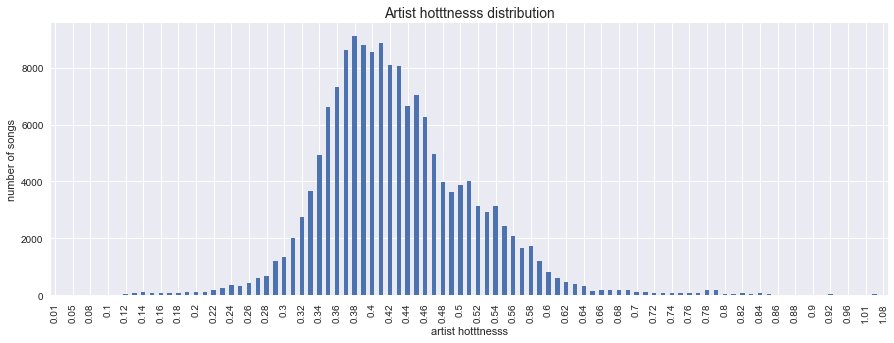

In [128]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data[data['artist hotttnesss'] > 0]['artist hotttnesss'], 2).value_counts().sort_index()\
    .plot(kind='bar',grid=True,figsize=(15, 5));
ax.set_title('Artist hotttnesss distribution', fontsize=14)
ax.set_xlabel('artist hotttnesss')
ax.set_ylabel('number of songs');

set_ticks_with_step(ax, 2)

In [129]:
# group by 'artist name' and take the average of the 'song hotttnesss's
artist_song_hotttnesss_avg = data.groupby('artist name')['artist name', 'song hotttnesss'].mean().reset_index()
artist_song_hotttnesss_avg.rename(columns = {'song hotttnesss':'song hotttnesss average'}, inplace=True)

print('Number of rows:', len(artist_song_hotttnesss_avg))
artist_song_hotttnesss_avg.head()

Number of rows: 24062


artist name  song hotttnesss average
0                !!!                 0.000000
1           !Deladap                 0.641668
2        #Poundsign#                 0.190498
3  $jammie the Money                 0.000000
4          $tinkworx                 0.277252

In [130]:
# keep the 'artist name' and the 'artist hotttnesss'
artist_hotttnesss = data[['artist name', 'artist hotttnesss']].drop_duplicates().reset_index(drop=True)

print('Number of rows:', len(artist_song_hotttnesss_avg))
artist_hotttnesss.head()

Number of rows: 24062


artist name  artist hotttnesss
0                Planet P Project           0.332276
1                    Adelitas Way           0.461318
2               Chaka Khan_ Rufus           0.398984
3               Western Addiction           0.386606
4  International Noise Conspiracy           0.414283

The number of artists matches in both dataframes, which means there is *a priori* no need to take the mean `artist hotttesss` for some artists.

In [131]:
df = pd.merge(artist_hotttnesss , artist_song_hotttnesss_avg, on='artist name', how='left')

print('Number of rows matched:', len(df))
df.head()

Number of rows matched: 25637


artist name  artist hotttnesss  song hotttnesss average
0                Planet P Project           0.332276                 0.267742
1                    Adelitas Way           0.461318                 0.627275
2               Chaka Khan_ Rufus           0.398984                 0.447145
3               Western Addiction           0.386606                 0.449893
4  International Noise Conspiracy           0.414283                 0.562186

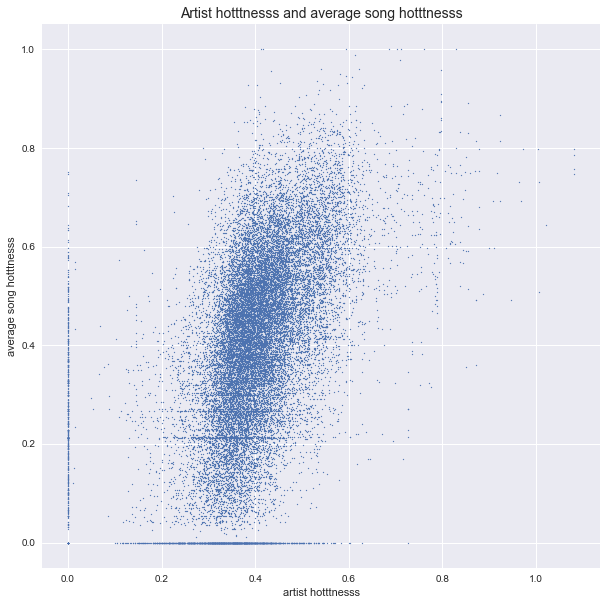

In [132]:
ax = df.plot.scatter(y='song hotttnesss average', x='artist hotttnesss', s=1, figsize=(10, 10));
ax.set_title('Artist hotttnesss and average song hotttnesss', fontsize=14)
ax.set_ylabel('average song hotttnesss')
ax.set_xlabel('artist hotttnesss');

plt.savefig('./report/images/artist_hotttnesss_vs_average_song_hotttnesss.png', dpi=100)

**Observations:**

There seems to be a correlation between the `song hotttnesss` of a song, and the corresponding `artist hotttnesss`.
What remains unclear though is whether one causes the other or not.

Not-so-popular artists, with an `artist hotttnesss` below 0.3, tend to produce songs which are not rated more than 0.6 for the `song hotttnesss`. 
Inversely, artists with an `artist hotttnesss` above 0.6, will have most of their songs rated above 0.4. 
What is interesting is that in between, the average `song hotttnesss` can be very low as well as very high.

What is more, the hotttessst artists do not seem to necessarily lead to the hotttessst songs, as can be seen for artists with an `artist hotttnesss` greater than 1.0: the corresponding average `song hotttnesss` then turns out to be below 0.8.

Beside plotting the average `song hotttnesss` for each artist, we also plot the `artist hotttnesss` and `song hotttnesss` for each single song.

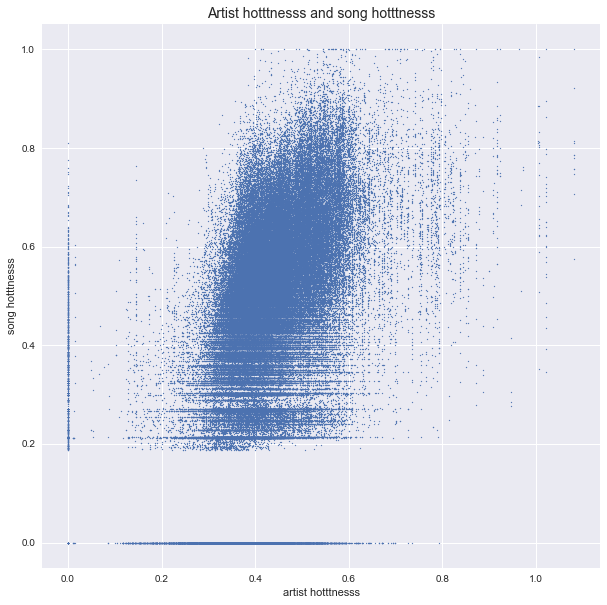

In [133]:
ax = data.plot.scatter(y='song hotttnesss', x='artist hotttnesss', s=1, figsize=(10, 10));
ax.set_title('Artist hotttnesss and song hotttnesss', fontsize=14)
ax.set_ylabel('song hotttnesss')
ax.set_xlabel('artist hotttnesss');

plt.savefig('./report/images/artist_hotttnesss_vs_song_hotttnesss.png', dpi=100)

In [134]:
threshold = 1.0
print('Highest song hotttnesss for artist with artist hotttnesss >=', threshold, ':', data[data['artist hotttnesss'] >= threshold]['song hotttnesss'].max())
print('Lowest song hotttnesss for artist with artist hotttnesss >=',  threshold, ':', data[data['artist hotttnesss'] >= threshold]['song hotttnesss'].min())

Highest song hotttnesss for artist with artist hotttnesss >= 1.0 : 1.0
Lowest song hotttnesss for artist with artist hotttnesss >= 1.0 : 0.345802233965


**Observations:**

The resulting plot, although similar to the previous one, now highlights better the variations in `song hotttnesss` and `artist hotttnesss` for very popular songs or artists.
At the same time, the correlation between the `artist hotttnesss` and the `song hotttnesss` becomes much less apparent.

* The large majority of songs have a `song hotttnesss` between 0.2 and 0.8
* The large majority of artists have an `artist hotttnesss` between 0.3 and 0.6
* Songs with a `song hotttnesss` of 1.0 are not associated with artists with an `artist hotttnesss` below 0.4
* Artists with an `artist hotttnesss` of 0.8 or more can produce equally many hot songs as not-so-hot songs 

**Conclusion:**

Despite the fact that the hotttessst songs seem to require a minimum `artist hotttnesss`, there is no need to be among the hotttessst artists in order to produce a song eventually rated hot.
In fact, the hotttessst artists produce songs with a `song hotttnesss` ranging from 1.0 to... 0.34.

<div class="lev2"><a href="#Table-of-Contents">Back to Top</a></div>
### Choosing a music style 

We analyse the relationship between the `artist terms` associated to a song, and its `song hotttnesss`.

In [786]:
data.head(1)

year  artist latitude  artist longitude  artist hotttnesss  \
0  1984              NaN               NaN           0.332276   

            artist id             song id       title  \
0  AR8ZCNI1187B9A069B  SOIAZJW12AB01853F1  Pink World   

                                        artist terms  \
0  [new wave, progressive rock, space rock, eurod...   

                                 artist terms weight  song hotttnesss  \
0  [1.0, 0.9869619197460081, 0.983064531867962, 0...         0.265861   

   danceability   duration  energy       artist name            track id  \
0             0  269.81832       0  Planet P Project  TRAAARJ128F9320760   

  artist location  
0

In [148]:
artist_terms = data['artist terms']
artist_terms_all = [item for sublist in artist_terms for item in sublist]
artist_terms_distinct = set(artist_terms_all)

print('Total number of artist terms:', len(artist_terms_all))
print('Number of distinct artist terms:', len(artist_terms_distinct))

Total number of artist terms: 5082794
Number of distinct artist terms: 6482


In [149]:
pd.Series(artist_terms_all).value_counts().sort_values(ascending=False).head(20)

rock                131337
pop                  98814
electronic           96684
alternative rock     75882
alternative          69619
indie                62706
hip hop              58751
jazz                 57699
indie rock           57193
united states        55522
pop rock             53863
punk                 53043
experimental         49539
folk                 48512
electro              43726
downtempo            42344
acoustic             41445
soul                 40073
ambient              39129
classic rock         38851
dtype: int64

The ranking of the `artist terms` in terms of occurences is very similar to the one in the MSD subset: `rock` at the top of the list, followed by `pop` and `electronic`. As a general trend, the `rock` oriented music seems to score highest.

In [158]:
threshold = 0.9
df = data[data['song hotttnesss'] >= threshold]
print('Number of songs selected:', len(df))

artist_terms = flatmap(df['artist terms'])
artist_terms_weight = flatmap(df['artist terms weight'])
artist_terms_tuples = list(zip(artist_terms, artist_terms_weight))

# filter out terms with "too low" weight (maybe)
threshold_weight = 0.7
#artist_terms_tuples = [item for item in artist_terms_tuples if item[1] >= threshold_weight]

Number of songs selected: 500


In [159]:
artist_terms_dict = defaultdict(list)

#group by term
for item in artist_terms_tuples:
    artist_terms_dict[item[0]].append(item[1])

# filter out artist terms occuring less than n times
n = 0
artist_terms_dict = {k: v for k, v in artist_terms_dict.items() if len(v) > n}
    
#compute the mean
for item in artist_terms_dict.items():
    #artist_terms_dict[item[0]] = (np.mean(item[1]), np.std(item[1]))
    artist_terms_dict[item[0]] = (sum(item[1]), len(item[1]))

artist_terms_sorted = sorted(artist_terms_dict.items(), key=lambda value: value[1][0], reverse=True)

In [160]:
sum_artist_weights = sum([value[0] for value in artist_terms_dict.values()])

print(len([value[0] for value in artist_terms_dict.values()]))
print(sum([value[0] for value in artist_terms_dict.values()]))
print(sum([(value[0]/sum_artist_weights)*100 for value in artist_terms_dict.values()]))

647
6905.72237308093
100.0000000000003


In [164]:
df = pd.DataFrame()
df['artist terms'] = [item[0] for item in artist_terms_sorted]
df['artist terms weight (%)'] = [(item[1][0]/sum_artist_weights)*100 for item in artist_terms_sorted]
df['count'] = [item[1][1] for item in artist_terms_sorted]
df.head(20)

artist terms  artist terms weight (%)  count
0               rock                 4.617761    426
1                pop                 3.738941    409
2        alternative                 2.493392    264
3              indie                 2.221263    256
4   alternative rock                 2.011225    188
5             guitar                 1.987991    308
6         indie rock                 1.904490    163
7           acoustic                 1.577093    231
8         electronic                 1.488118    182
9         soundtrack                 1.482128    172
10              soul                 1.328866    180
11      classic rock                 1.181799    116
12              punk                 1.166998    149
13              folk                 1.084763    130
14          pop rock                 1.081810     86
15         hard rock                 1.048990     95
16              jazz                 1.040714    115
17             metal                 1.011965    125
18          new wave                 0.999665     99
19       heavy metal                 0.968241     78

**Observations:**

Like in the ranking counting the absolute number of occurences of each `artist term`, `rock`, `pop`, `alternative` and `alternative rock` score top also when the `artist terms` are weighted with the corresponding `artist term weights`.

Percentages of top music styles decrease when the `song hotttnesss` threshold decreases as well (the less popular selected songs add more music styles).

**Conclusion:**

Recipe in terms of music style: XX.XX% of rock, XX.XX% of pop, XX.XX% of alternative, ... 

Follow exactly these percentages in order to increase your chances of making a "hot" song.



### Side note: Energy and Danceability
Unfortunately, both features, which were not evaluated for any of the song in the Million Song Dataset, still appear to not be evaluated when taking a larger sample (i.e. all values are set to 0.0).
Although it could have been interesting to compare the `song hotttnesss` to these two features, in the end, we did not use them at all in our analysis.

In [1696]:
describe(data, 'energy', True)

energy
count  159430.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0

In [1682]:
describe(data, 'danceability', True)

danceability
count      159430.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0

<div class="lev2"><a href="#Table-of-Contents">Back to Top</a></div>

### How much songs where played

In [3]:
path_triplets = './data/triplets/'

In [4]:
# load the 'full_word_list.txt' file, containing all the words present in all the songs
data_triplets = pd.read_csv(path_triplets+'train_triplets.txt', sep='\t', header=None, engine='python')
data_triplets.columns = ['user', 'song', 'plays']

In [5]:
print('Number of triplets:', len(data_triplets))
data_triplets.head()

Number of triplets: 48373586


user                song  plays
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995      1
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9      1
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B      2
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22      1
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFOVM12A58A7D494      1

In [145]:
plays_by_song = data_triplets.groupby('song').sum()

In [146]:
plays_by_song = plays_by_song.sort_values('plays', ascending=False)
plays_by_song.head(3)

plays
song                      
SOBONKR12A58A7A7E0  726885
SOAUWYT12A81C206F1  648239
SOSXLTC12AF72A7F54  527893

In [147]:
plays_by_song.describe()

plays
count  384546.000000
mean      360.633690
std      3256.809395
min         1.000000
25%         8.000000
50%        32.000000
75%       133.000000
max    726885.000000

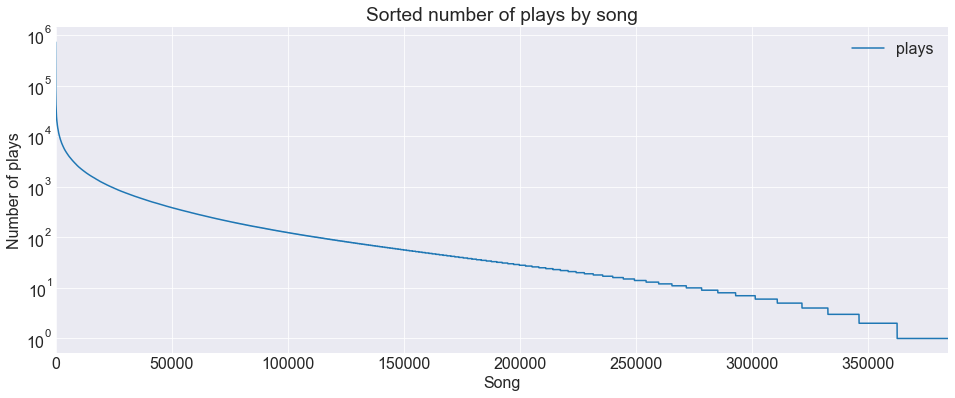

In [156]:
seaborn.set_style('darkgrid')
plays_by_song.reset_index().plot(logy=True, figsize=(16,6))
plt.title("Sorted number of plays by song")
plt.xlabel("Song")
plt.ylabel("Number of plays")

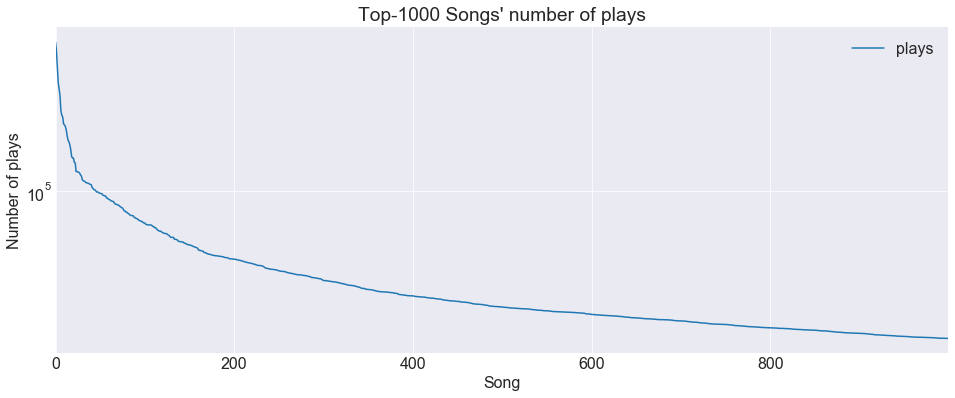

In [155]:
seaborn.set_style('darkgrid')
plays_by_song.head(1000).reset_index().plot(logy=True, figsize=(16,6))
plt.title("Top-1000 Songs' number of plays")
plt.xlabel("Song")
plt.ylabel("Number of plays")

In [158]:
# Normalize the number of plays so that we get a ranking between 0 and 1
m = plays_by_song.max()
plays_by_song['plays'] = plays_by_song['plays'].map(lambda x: x / m)
plays_by_song.head(3)

plays
song                                                
SOBONKR12A58A7A7E0       plays    1.0
dtype: float64
SOAUWYT12A81C206F1  plays    0.891804
dtype: float64
SOSXLTC12AF72A7F54   plays    0.72624
dtype: float64

In [167]:
# Look at only the top-x played_song 
top_nbr_song = 20
top_songs = plays_by_song.head(top_nbr_song)
#top_songs = top_songs.reset_index() # Add a numerical index to keep their rank
ts = list(top_songs.index.values)

In [168]:
# You can use directly the whole data dataframe here. (instead of making a copy in exp)
exp = data.copy() 

In [169]:
exp[exp['song id'].isin(ts)][['title', 'song id', 'song hotttnesss']]

title             song id  song hotttnesss
2300    You're The One  SOBONKR12A58A7A7E0         0.476435
91631             Undo  SOAUWYT12A81C206F1         0.937443
117974         Invalid  SOUFTBI12AB0183F65         0.413740
141758        Marry Me  SOTWNDJ12A8C143984         1.000000

<div class="lev2"><a href="#Table-of-Contents">Back to Top</a></div>
### Clustering behaviour in plays ?
Let's turn our interest into visualizing if there is some clustering effect between users listening to music

In [21]:
print("Number of users :", data_triplets['user'].unique().size)

Number of users : 1019318


We proceed to an exploratory analysis on a subset first.

In [33]:
subset_size = 30 # number of users in the subset

subset_userID = list(data_triplets['user'].unique())[:subset_size]

triplets_subset = data_triplets[data_triplets['user'].isin(list(subset_userID))]
triplets_subset.shape

(1824, 3)

In [34]:
G = nx.from_pandas_dataframe(triplets_subset, 'user', 'song', 'plays')

# Compute the list of users and songs in order to plot them distincly in the graph
users = list(triplets_subset.groupby('user').count().index.values)
songs = list(triplets_subset.groupby('song').count().index.values)

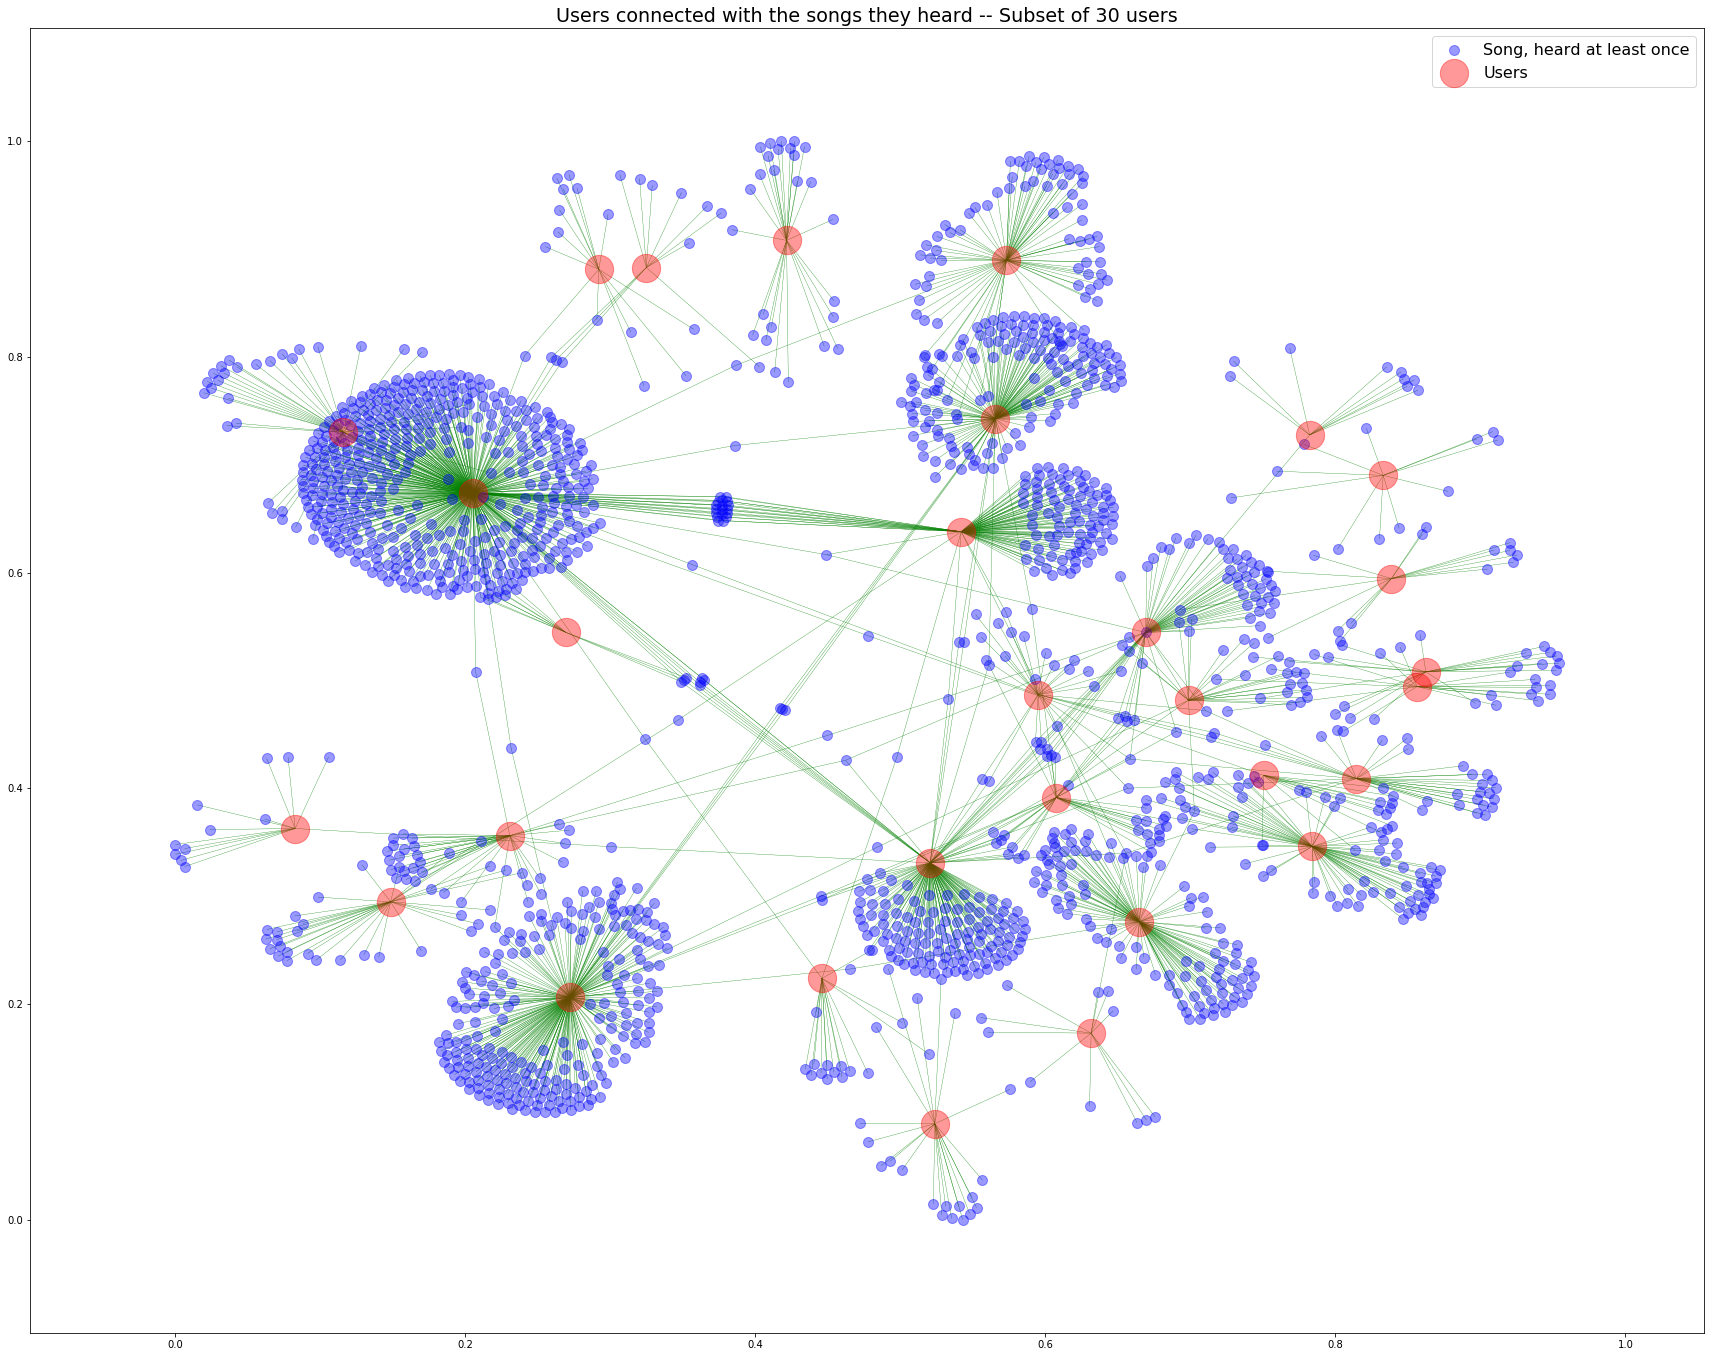

In [35]:
plt.figure(figsize=(30,24))
pos=nx.spring_layout(G, k=0.1, iterations=70)

nx.draw_networkx_edges(G, pos, edge_color='g', width=0.3)

nx.draw_networkx(G, pos, label="Song, heard at least once",
                 nodelist = songs,
                 edgelist=[],
                 node_color='b',
                 node_size = 100,
                 alpha=0.4,
                 with_labels=False, font_weight='bold')
nx.draw_networkx(G, pos, label="Users",
                 nodelist = users,
                 edgelist=[],
                 node_color='r',
                 node_size = 800,
                 alpha=0.4,
                 with_labels=False, font_weight='bold')

plt.rcParams['font.size'] = 16
plt.legend()
plt.title('Users connected with the songs they heard -- Subset of '+ str(subset_size)+' users')
#plt.savefig('users_songs')

Since it's a bit chaotic, let's try to plot only 2-connected songs. (Those which link 2 or more users)

#### We continue the analysis with a small subset in order to visualize the result

In [36]:
doubly_connected_songs = triplets_subset[triplets_subset['plays'] > 0].groupby('song')['plays'].count()
dcs = list(doubly_connected_songs[doubly_connected_songs.values > 1].index.values)

triplets_subset_connected = triplets_subset[triplets_subset.song.isin(dcs)]

In [37]:
G = nx.from_pandas_dataframe(triplets_subset_connected, 'user', 'song', 'plays')

users = list(triplets_subset_connected.groupby('user').count().index.values)
print("Number of users still in the graph : ",len(users), 
      "\nNumber of users : ", subset_size, 
      "\nProportion : ", round(len(users)/subset_size, 2))

Number of users still in the graph :  23 
Number of users :  30 
Proportion :  0.77


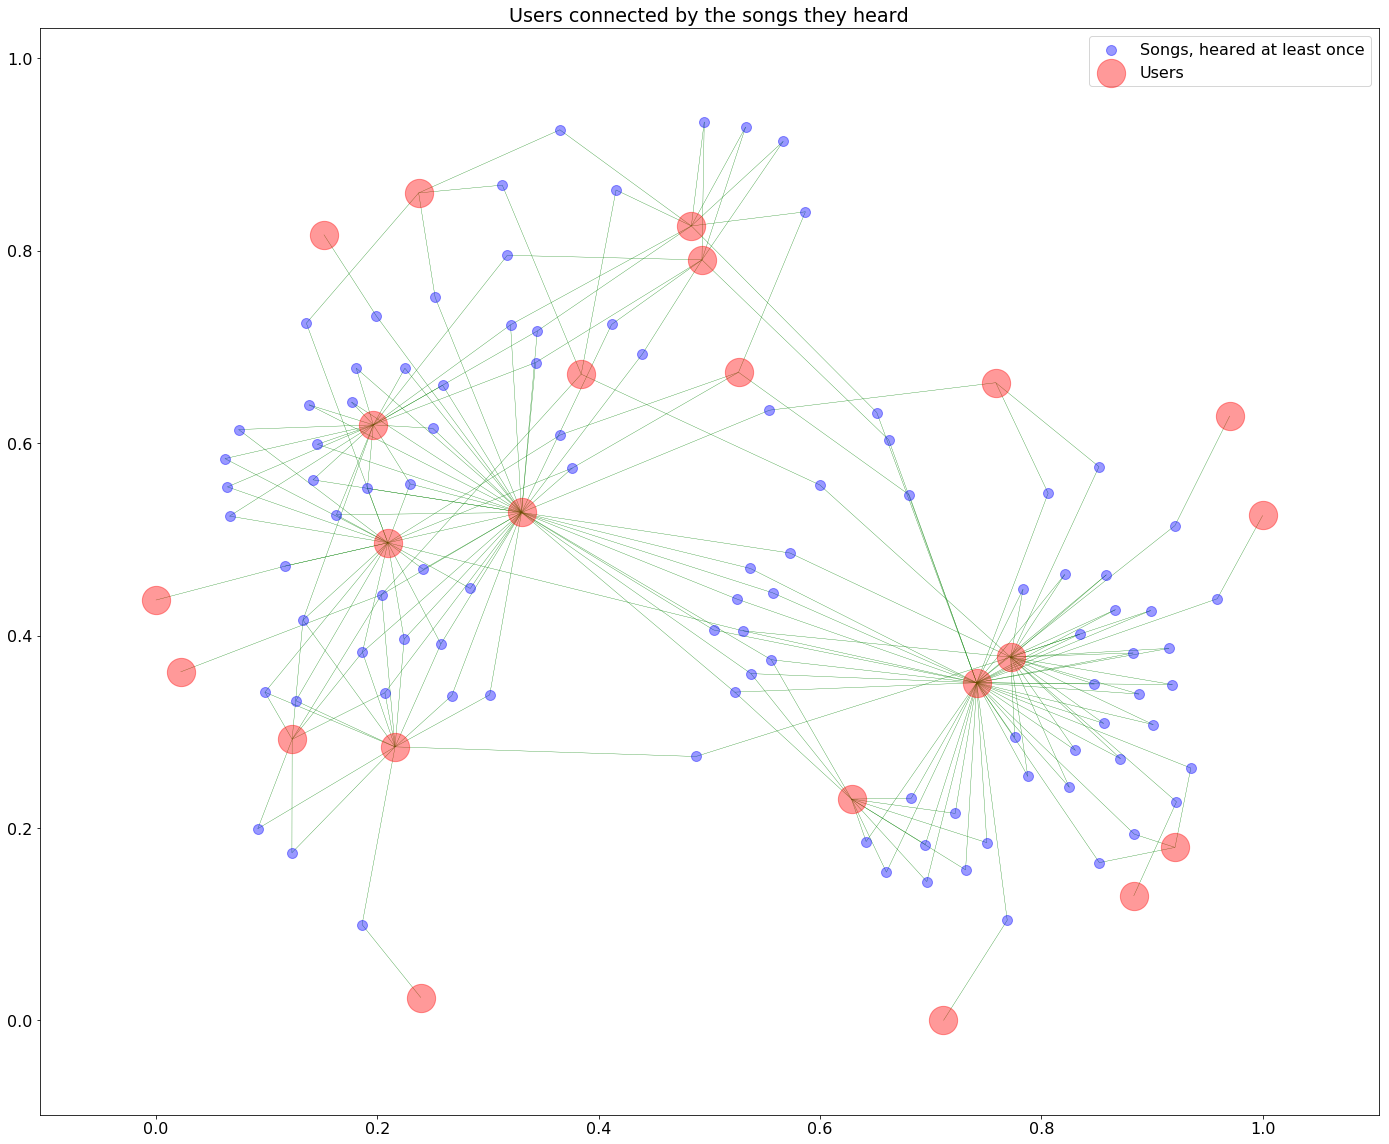

In [42]:
plt.figure(figsize=(24,20))
pos=nx.spring_layout(G, k=0.06, iterations=100) # Those parameters allow to arrange the graph 


nx.draw_networkx_edges(G, pos, edge_color='g', width=0.3)

nx.draw_networkx(G, pos, label='Songs, heared at least once',
                 nodelist = dcs,
                 edgelist=[],
                 node_color='b',
                 node_size = 100,
                 alpha=0.4,
                 with_labels=False, font_weight='bold')

nx.draw_networkx(G, pos, label='Users',
                 nodelist = users,
                 edgelist=[],
                 node_color='r',
                 node_size = 800,
                 alpha=0.4,
                 with_labels=False, font_weight='bold')

plt.rcParams['font.size'] = 16
plt.legend()
plt.title('Users connected by the songs they heard')

** Observations **
* All users are connected
* We can still expect some clusters inside the graph.

Hence, since we cannot apply this to the whole data (it would be unreadable), we will try to apply the Louvain method.
This method is used in large networks to unfold communities

#### Connected users
First of all we are interested only in users having heard the same songs (and not the songs themselves)

So now from a graph `G`, we compute a new graph `G_connected` where nodes are users, connected iff they heard a song in common

<div class="alert alert-info">
An improvement for the following would be to keep track of how much songs they heard in common, and take it as the weight of edge between users.
</div>

In [43]:
import itertools
import community
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

In [44]:
connected_components_users = []
for conn in list(nx.connected_components(G)):
    connected_components_users.append(list(conn.intersection(set(users))))

In [45]:
u1, u2 = [], []
df_users_conn = pd.DataFrame(columns=['u1','u2'])

for users_conn in connected_components_users:
    for user in users_conn:
        neighbour_songs = G.neighbors(user)
        for n_s in neighbour_songs:
            neighbours = G.neighbors(n_s)
            neighbours.remove(user)
            for n in neighbours:
                u1.append(user)
                u2.append(n)

In [ ]:
#old -> too slow
"""u1, u2 = [], []
for users_conn in connected_components_users:
    for u in itertools.combinations(users_conn, 2):
        if nx.shortest_path_length(G, u[0], u[1]) == 2:
            u1.append(u[0])
            u2.append(u[1])"""

In [46]:
df_users_conn = pd.DataFrame(u1, u2).reset_index()
df_users_conn.columns = ['u1', 'u2']

In [47]:
G_connected = nx.from_pandas_dataframe(df_users_conn, 'u1', 'u2')

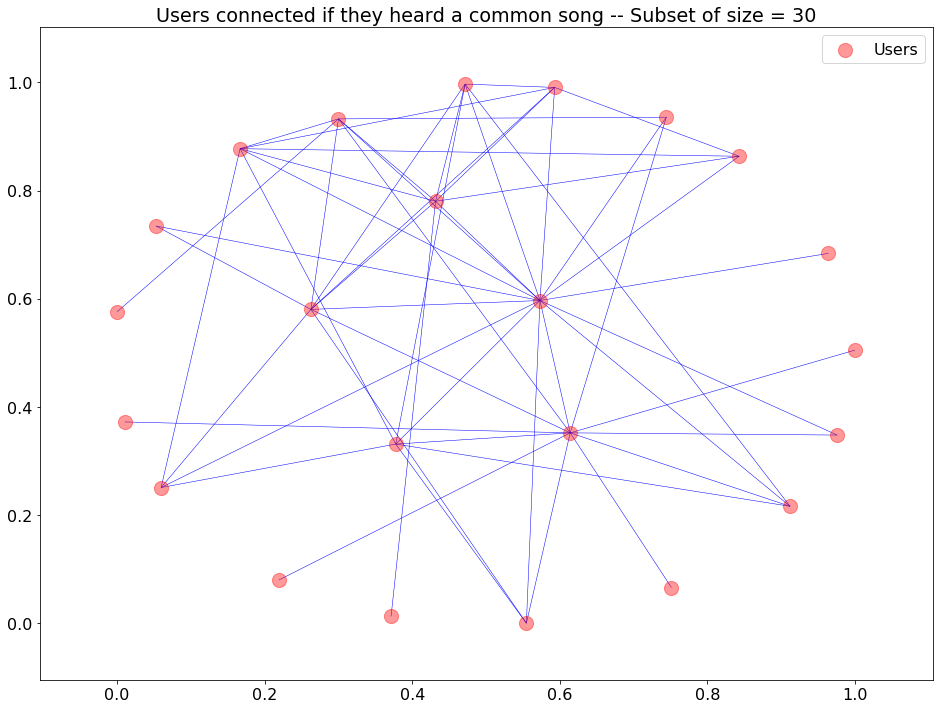

In [53]:
plt.figure(figsize=(16,12))
pos=nx.spring_layout(G_connected, k=0.4, iterations=70) # Those parameters allow to arrange the graph 

nx.draw_networkx_edges(G_connected, pos, edge_color='b', width=0.5)

nx.draw_networkx(G_connected, pos, label='Users',
                 edgelist=[],
                 node_color='r',
                 node_size = 200,
                 alpha=0.4,
                 with_labels=False, 
                 font_weight='bold')

plt.rcParams['font.size'] = 16
plt.legend()
plt.title('Users connected if they heard a common song -- Subset of size = '+ str(subset_size))

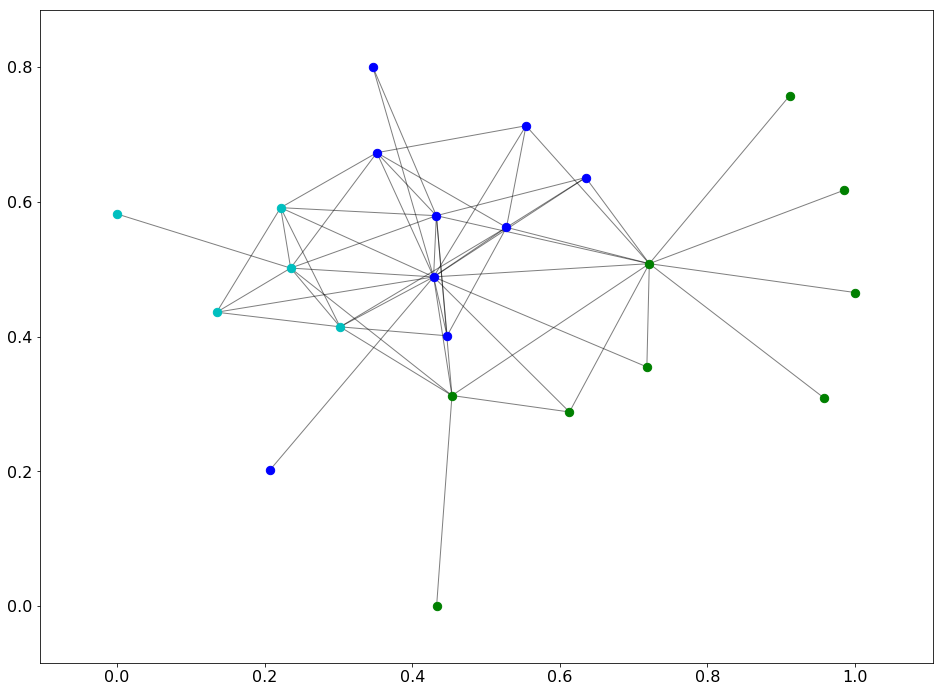

In [54]:
# Put the graph you want to analyse :
G_louvain = G_connected.copy()

#first compute the best partition
partition = community.best_partition(G_louvain)

# Drawing
plt.figure(figsize=(16,12))

size = float(len(set(partition.values())))
pos = nx.spring_layout(G_louvain, k=0.15, iterations=70)
count = 0.

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, 
                           list_nodes, 
                           node_size = 70,
                           node_color = colors[int(count)])


nx.draw_networkx_edges(G_louvain, pos, alpha=0.5)
plt.show()

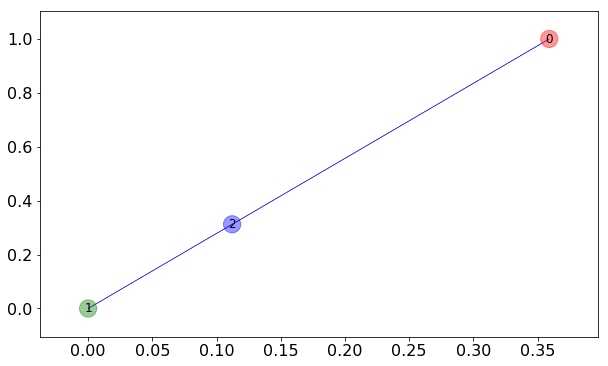

In [57]:
induced_graph = community.induced_graph(partition, G_connected)

#w = list((df_clusters.groupby('partition').count().values)[:,0])
#mapping = dict(zip(list(range(len(w))), w))
#induced_graph = nx.relabel_nodes(induced_graph, mapping)

# Draw it
plt.figure(figsize=(10,6))
pos=nx.spring_layout(induced_graph, k=0.3) # Those parameters allow to arrange the graph 

nx.draw_networkx_edges(induced_graph, pos, edge_color='b', width=0.5)

nx.draw_networkx(induced_graph, pos, label='Community',
                 edgelist=[],
                 node_color=colors,
                 node_size = 300,
                 alpha=0.4,
                 with_labels=True, 
                 )

In [58]:
df_clusters = pd.DataFrame.from_dict(partition, 'index').reset_index()
df_clusters.columns = ['user', 'partition']
df_clusters.groupby('partition').count()

user
partition      
0             9
1             9
2             5

#### Now let's apply Louvain to a much larger subset

In [59]:
subset_size = 10000 # number of users in the subset

subset_userID = list(data_triplets['user'].unique())[:subset_size]

triplets_subset = data_triplets[data_triplets['user'].isin(list(subset_userID))]

#####

doubly_connected_songs = triplets_subset[triplets_subset['plays'] > 0].groupby('song')['plays'].count()
dcs = list(doubly_connected_songs[doubly_connected_songs.values > 1].index.values)

triplets_subset_connected = triplets_subset[triplets_subset.song.isin(dcs)]

#####

G = nx.from_pandas_dataframe(triplets_subset_connected, 'user', 'song', 'plays')

users = list(triplets_subset_connected.groupby('user').count().index.values)
print("Number of users still in the graph : ",len(users), 
      "\nNumber of users : ", subset_size, 
      "\nProportion : ", round(len(users)/subset_size, 3))

Number of users still in the graph :  9999 
Number of users :  10000 
Proportion :  1.0


From this we see that the more user we use, the more connected they are. So we expect that the whole data is just one giant connected component.

In [60]:
connected_components_users = []
for conn in list(nx.connected_components(G)):
    connected_components_users.append(list(conn.intersection(set(users))))

In [61]:
u1, u2 = [], []
df_users_conn = pd.DataFrame(columns=['u1','u2'])

for e,users_conn in enumerate(connected_components_users):
    print("Component ", e+1, ' on ', len(connected_components_users))
    for user in users_conn:
        neighbour_songs = G.neighbors(user)
        for n_s in neighbour_songs:
            neighbours = G.neighbors(n_s)
            neighbours.remove(user)
            for n in neighbours:
                u1.append(user)
                u2.append(n)
    

Component  1  on  1


In [62]:
df_users_conn = pd.DataFrame(u1, u2).reset_index()
df_users_conn.columns = ['u1', 'u2']

In [63]:
G_connected = nx.from_pandas_dataframe(df_users_conn, 'u1', 'u2')

In [ ]:
#This just draws a giant cloud of nodes...
"""plt.figure(figsize=(16,12))
pos=nx.spring_layout(G_connected, k=0.3, iterations=10) # Those parameters allow to arrange the graph 

nx.draw_networkx_edges(G_connected, pos, edge_color='b', width=0.1)

nx.draw_networkx(G_connected, pos, label='Users',
                 edgelist=[],
                 node_color='r',
                 node_size = 200,
                 alpha=0.4,
                 with_labels=False, 
                 font_weight='bold')

plt.rcParams['font.size'] = 16
plt.legend()
plt.title('Users connected if they heard a common song -- Subset of size = '+ str(subset_size))"""

In [64]:
# Put the graph you want to analyse :
G_louvain = G_connected.copy()

#first compute the best partition
partition = community.best_partition(G_louvain)

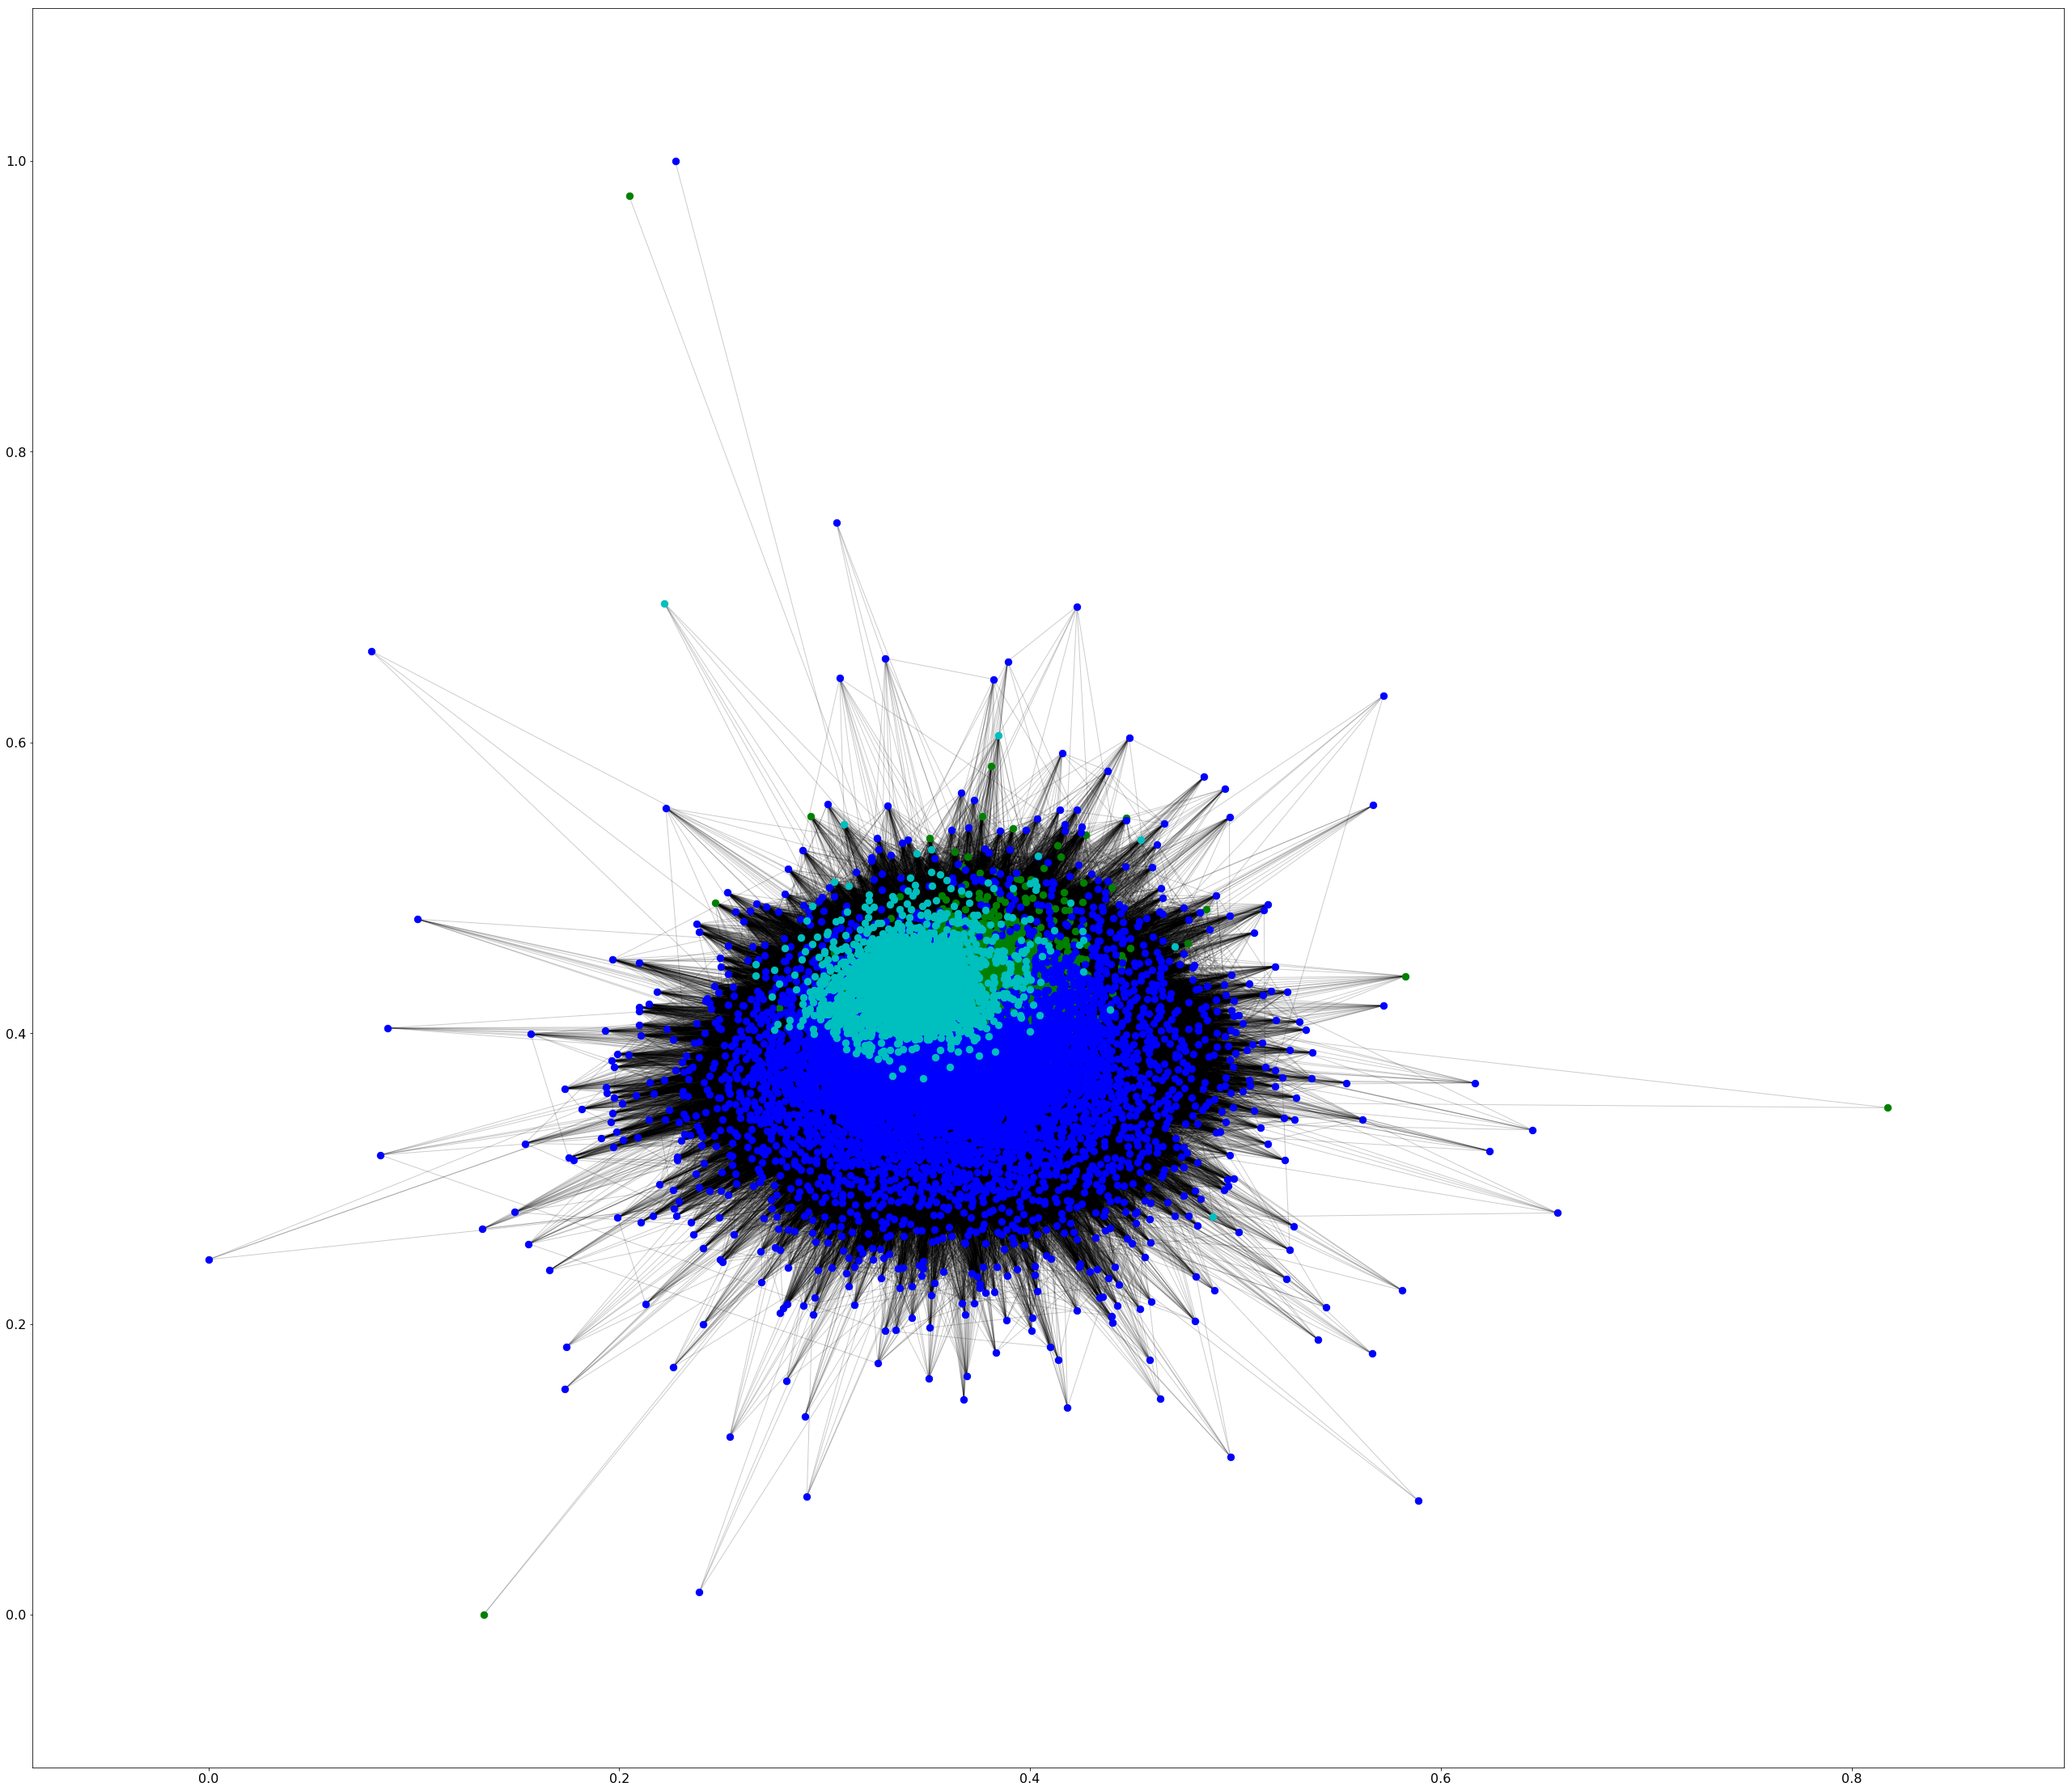

In [68]:
# Drawing
#plt.figure(figsize=(16,12))
plt.figure(figsize=(45,40)) #saving in huge format

size = float(len(set(partition.values())))
pos = nx.spring_layout(G_louvain, k=0.15, iterations=100)
count = 0.

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, 
                           list_nodes, 
                           node_size = 70,
                           node_color = colors[int(count)])

nx.draw_networkx_edges(G_louvain, pos, alpha=0.2)
plt.show()
plt.savefig("graph.png", dpi=500)

In [65]:
induced_graph = community.induced_graph(partition, G_connected)

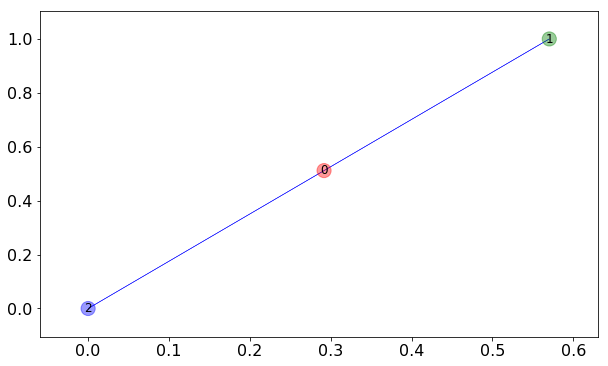

In [66]:
# Draw it
plt.figure(figsize=(10,6))
pos=nx.spring_layout(induced_graph, k=0.3, iterations=50) # Those parameters allow to arrange the graph 

nx.draw_networkx_edges(induced_graph, pos, edge_color='b', width=0.5)

nx.draw_networkx(induced_graph, pos, label='Users',
                 edgelist=[],
                 node_color=colors,
                 node_size = 200,
                 alpha=0.4,
                 with_labels=True
                 )

In [67]:
df_clusters = pd.DataFrame.from_dict(partition, 'index').reset_index()
df_clusters.columns = ['user', 'partition']
df_clusters.groupby('partition').count()

user
partition      
0          2329
1          5607
2          2063

**THE END**